# IEEE Fraud Detection Kaggle Competition

features from: https://www.kaggle.com/roydatascience/light-gbm-with-complete-eda/notebook#Feature-Engineering

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

num_folds = 5
SEED = 5000

In [3]:
import random, os
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything()

In [4]:
sampled_train_original = pd.read_csv('../../output/sampled_train_reduced_mem.csv')
train_original = pd.read_csv('../../output/train_reduced_mem.csv')
test_original = pd.read_csv('../../output/test_reduced_mem.csv')

In [11]:
params = {
                'objective':'binary',
                'boosting_type':'gbdt',
                'metric':'auc',
                'n_jobs':-1,
                'learning_rate':0.064,
                'num_leaves': 2**8,
                'max_depth':-1,
                'tree_learner':'serial',
                'colsample_bytree': 0.85,
                'subsample_freq':1,
                'subsample':0.85,
                'max_bin':255,
                'verbose':-1,
                'seed': SEED,
                'reg_alpha':0.3,
                'reg_lamdba':0.243
            } 
# Uses a lower learning rate - default is 0.1. This is not changed in my notebooks, try again with this change?
params['learning_rate'] = 0.005
params['n_estimators'] = 3000
# params['n_estimators'] = 550
params['early_stopping_rounds'] = 100    

In [6]:
sampled_train_original.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionWeek
0,2996780,0,302413,25.98,C,4461,375.0,185.0,mastercard,224.0,debit,NaN,NaN,NaN,NaN,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,334122.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,NaN,New,NotFound,225.0,NaN,266.0,325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,F3213 Build/36.1.

In [7]:
n_days_in_week_21 = 18509

In [8]:
"""
This module provides a class to split time-series data for back-testing and evaluation.
The aim was to extend the current sklearn implementation and extend it's uses.

Might be useful for some ;)
"""

import logging
from typing import Optional

import numpy as np
from sklearn.model_selection._split import _BaseKFold
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples

LOGGER = logging.getLogger(__name__)


class TimeSeriesSplit(_BaseKFold):  # pylint: disable=abstract-method
    """Time Series cross-validator

    Provides train/test indices to split time series data samples that are observed at fixed time intervals,
    in train/test sets. In each split, test indices must be higher than before, and thus shuffling in cross validator is
    inappropriate.

    This cross_validation object is a variation of :class:`TimeSeriesSplit` from the popular scikit-learn package.
    It extends its base functionality to allow for expanding windows, and rolling windows with configurable train and
    test sizes and delays between each. i.e. train on weeks 1-8, skip week 9, predict week 10-11.

    In this implementation we specifically force the test size to be equal across all splits.

    Expanding Window:

            Idx / Time  0..............................................n
            1           |  train  | delay |  test  |                   |
            2           |       train     | delay  |  test  |          |
            ...         |                                              |
            last        |            train            | delay |  test  |

    Rolling Windows:
            Idx / Time  0..............................................n
            1           | train   | delay |  test  |                   |
            2           | step |  train  | delay |  test  |            |
            ...         |                                              |
            last        | step | ... | step |  train  | delay |  test  |

    Parameters:
        n_splits : int, default=5
            Number of splits. Must be at least 4.

        train_size : int, optional
            Size for a single training set.

        test_size : int, optional, must be positive
            Size of a single testing set

        delay : int, default=0, must be positive
            Number of index shifts to make between train and test sets
            e.g,
            delay=0
                TRAIN: [0 1 2 3] TEST: [4]
            delay=1
                TRAIN: [0 1 2 3] TEST: [5]
            delay=2
                TRAIN: [0 1 2 3] TEST: [6]

        force_step_size : int, optional
            Ignore split logic and force the training data to shift by the step size forward for n_splits
            e.g
            TRAIN: [ 0  1  2  3] TEST: [4]
            TRAIN: [ 0  1  2  3  4] TEST: [5]
            TRAIN: [ 0  1  2  3  4  5] TEST: [6]
            TRAIN: [ 0  1  2  3  4  5  6] TEST: [7]

    Examples
    --------
    >>> X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
    >>> y = np.array([1, 2, 3, 4, 5, 6])
    >>> tscv = TimeSeriesSplit(n_splits=5)
    >>> print(tscv)  # doctest: +NORMALIZE_WHITESPACE
    TimeSeriesSplit(train_size=None, n_splits=5)
    >>> for train_index, test_index in tscv.split(X):
    ...    print('TRAIN:', train_index, 'TEST:', test_index)
    ...    X_train, X_test = X[train_index], X[test_index]
    ...    y_train, y_test = y[train_index], y[test_index]
    TRAIN: [0] TEST: [1]
    TRAIN: [0 1] TEST: [2]
    TRAIN: [0 1 2] TEST: [3]
    TRAIN: [0 1 2 3] TEST: [4]
    TRAIN: [0 1 2 3 4] TEST: [5]
    """

    def __init__(self,
                 n_splits: Optional[int] = 5,
                 train_size: Optional[int] = None,
                 test_size: Optional[int] = None,
                 delay: int = 0,
                 force_step_size: Optional[int] = None):

        if n_splits and n_splits < 5:
            raise ValueError(f'Cannot have n_splits less than 5 (n_splits={n_splits})')
        super().__init__(n_splits, shuffle=False, random_state=None)

        self.train_size = train_size

        if test_size and test_size < 0:
            raise ValueError(f'Cannot have negative values of test_size (test_size={test_size})')
        self.test_size = test_size

        if delay < 0:
            raise ValueError(f'Cannot have negative values of delay (delay={delay})')
        self.delay = delay

        if force_step_size and force_step_size < 1:
            raise ValueError(f'Cannot have zero or negative values of force_step_size '
                             f'(force_step_size={force_step_size}).')

        self.force_step_size = force_step_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.

        Parameters:
            X : array-like, shape (n_samples, n_features)
                Training data, where n_samples is the number of samples  and n_features is the number of features.

            y : array-like, shape (n_samples,)
                Always ignored, exists for compatibility.

            groups : array-like, with shape (n_samples,), optional
                Always ignored, exists for compatibility.

        Yields:
            train : ndarray
                The training set indices for that split.

            test : ndarray
                The testing set indices for that split.
        """
        X, y, groups = indexable(X, y, groups)  # pylint: disable=unbalanced-tuple-unpacking
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        delay = self.delay

        if n_folds > n_samples:
            raise ValueError(f'Cannot have number of folds={n_folds} greater than the number of samples: {n_samples}.')

        indices = np.arange(n_samples)
        split_size = n_samples // n_folds

        train_size = self.train_size or split_size * self.n_splits
        test_size = self.test_size or n_samples // n_folds
        full_test = test_size + delay

        if full_test + n_splits > n_samples:
            raise ValueError(f'test_size\\({test_size}\\) + delay\\({delay}\\) = {test_size + delay} + '
                             f'n_splits={n_splits} \n'
                             f' greater than the number of samples: {n_samples}. Cannot create fold logic.')

        # Generate logic for splits.
        # Overwrite fold test_starts ranges if force_step_size is specified.
        if self.force_step_size:
            step_size = self.force_step_size
            final_fold_start = n_samples - (train_size + full_test)
            range_start = (final_fold_start % step_size) + train_size

            test_starts = range(range_start, n_samples, step_size)

        else:
            if not self.train_size:
                step_size = split_size
                range_start = (split_size - full_test) + split_size + (n_samples % n_folds)
            else:
                step_size = (n_samples - (train_size + full_test)) // n_folds
                final_fold_start = n_samples - (train_size + full_test)
                range_start = (final_fold_start - (step_size * (n_splits - 1))) + train_size

            test_starts = range(range_start, n_samples, step_size)

        # Generate data splits.
        for test_start in test_starts:
            idx_start = test_start - train_size if self.train_size is not None else 0
            # Ensure we always return a test set of the same size
            if indices[test_start:test_start + full_test].size < full_test:
                continue
            yield (indices[idx_start:test_start],
                   indices[test_start + delay:test_start + full_test])

# Feature Engineering

In [9]:
sampled_train_original.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionWeek
0,2996780,0,302413,25.98,C,4461,375.0,185.0,mastercard,224.0,debit,NaN,NaN,NaN,NaN,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,334122.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,NaN,New,NotFound,225.0,NaN,266.0,325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,F3213 Build/36.1.

In [10]:
one_value_cols = [col for col in train_original.columns if train_original[col].nunique() <= 1]
one_value_cols_test = [col for col in test_original.columns if test_original[col].nunique() <= 1]

many_null_cols = [col for col in train_original.columns if train_original[col].isnull().sum() / train_original.shape[0] > 0.9]
many_null_cols_test = [col for col in test_original.columns if test_original[col].isnull().sum() / test_original.shape[0] > 0.9]

big_top_value_cols = [col for col in train_original.columns if train_original[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test_original.columns if test_original[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols + one_value_cols_test))
cols_to_drop.remove('isFraud')
print('{} features are going to be dropped for being useless'.format(len(cols_to_drop)))

sampled_train_original = sampled_train_original.drop(cols_to_drop, axis=1)
train_original = train_original.drop(cols_to_drop, axis=1)
test_original = test_original.drop(cols_to_drop, axis=1)

82 features are going to be dropped for being useless


In [12]:
sampled_train = sampled_train_original.copy()
train = train_original.copy()
test = test_original.copy()

In [13]:
sampled_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V56,V57,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V79,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionWeek
0,2996780,0,302413,25.98,C,4461,375.0,185.0,mastercard,224.0,debit,NaN,NaN,NaN,gmail.com,gmail.com,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,334122.0,NaN,NaN,0.0,0.0,NaN,NaN,100.0,NotFound,NaN,NaN,New,NotFound,225.0,266.0,325.0,New,NotFound,NaN,chrome 62.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,F3213 Build/36.1.A.1.86,1.0
1,2996781,0,302415,250.00,R,13979,474.0,150.0,visa,226.0,credit,476.0,87.0,NaN,yahoo.com,anonymous.com,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [14]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V56,V57,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V79,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [15]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V56,V57,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V79,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,gmail.com,NaN,6.0,6.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.00,47.95,0.00,47.95,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.00,47.95,0.00,47.95,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,aol.com,NaN,3.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,231.0,634.0,NaN,NaN,NaN,634.0,T,F,F,M0,NaN,F,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,4.0,1.0,0.00,280.00,77.00,280.00,77.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [16]:
valid_card = train['card1'].value_counts()
valid_card = valid_card[valid_card>10]
valid_card = list(valid_card.index)

sampled_train['card1'] = np.where(sampled_train['card1'].isin(valid_card), sampled_train['card1'], np.nan)
train['card1'] = np.where(train['card1'].isin(valid_card), train['card1'], np.nan)
test['card1'] = np.where(test['card1'].isin(valid_card), test['card1'], np.nan)

In [17]:
i_cols = ['card1','card2','card3','card5',
          'C1','C2','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D8','D9',
          'addr1','addr2',
          'dist1',
          'P_emaildomain', 'R_emaildomain',
          'M5'
         ]

for col in i_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()   
    
    sampled_train[col+'_fq_enc'] = sampled_train[col].map(fq_encode)
    train[col+'_fq_enc'] = train[col].map(fq_encode)
    test[col+'_fq_enc'] = test[col].map(fq_encode)

In [18]:
for col in ['ProductCD','M4']:
    temp_dict = train.groupby([col])['isFraud'].agg(['mean']).reset_index().rename(
                                                        columns={'mean': col+'_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col+'_target_mean'].to_dict()
    
    sampled_train[col+'_target_mean'] = sampled_train[col].map(temp_dict)
    train[col+'_target_mean'] = train[col].map(temp_dict)
    test[col+'_target_mean'] = test[col].map(temp_dict)

In [19]:
from sklearn.preprocessing import LabelEncoder

for col in list(train):
    if train[col].dtype=='O':
        print(col)
        sampled_train[col] = sampled_train[col].fillna('unseen_before_label')
        train[col] = train[col].fillna('unseen_before_label')
        test[col]  = test[col].fillna('unseen_before_label')
        
        sampled_train[col] = sampled_train[col].astype(str)
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        
        le = LabelEncoder()
        le.fit(list(train[col])+list(test[col]))
        sampled_train[col] = le.transform(sampled_train[col])
        train[col] = le.transform(train[col])
        test[col] = le.transform(test[col])

ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_12
id_15
id_16
id_28
id_29
id_30
id_31
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo


In [20]:
i_cols = ['card1','card2','card3','card5','addr1']

for col in i_cols:
    for agg_type in ['mean', 'std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})
        
        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   
        
        sampled_train[new_col_name] = sampled_train[col].map(temp_df)
        train[new_col_name] = train[col].map(temp_df)
        test[new_col_name] = test[col].map(temp_df)

In [21]:
train['card_TransactionAmt_ave']=train[['card1_TransactionAmt_mean', 'card2_TransactionAmt_mean',
                                             'card3_TransactionAmt_mean', 'card5_TransactionAmt_mean']].mean(axis=1)
test['card_TransactionAmt_ave']=test[['card1_TransactionAmt_mean', 'card2_TransactionAmt_mean',
                                             'card3_TransactionAmt_mean', 'card5_TransactionAmt_mean']].mean(axis=1)
sampled_train['card_TransactionAmt_ave']=sampled_train[['card1_TransactionAmt_mean', 'card2_TransactionAmt_mean',
                                             'card3_TransactionAmt_mean', 'card5_TransactionAmt_mean']].mean(axis=1)

# train['card1_TransactionAmt_ratio'] = train['TransactionAmt'] / train['card1_TransactionAmt_mean']
# test['card1_TransactionAmt_ratio'] = test['TransactionAmt'] / test['card1_TransactionAmt_mean']
# sampled_train['card1_TransactionAmt_ratio'] = sampled_train['TransactionAmt'] / sampled_train['card1_TransactionAmt_mean']

# train['card2_TransactionAmt_ratio'] = train['TransactionAmt'] / train['card2_TransactionAmt_mean']
# test['card2_TransactionAmt_ratio'] = test['TransactionAmt'] / test['card2_TransactionAmt_mean']
# sampled_train['card2_TransactionAmt_ratio'] = sampled_train['TransactionAmt'] / sampled_train['card2_TransactionAmt_mean']

# train['card3_TransactionAmt_ratio'] = train['TransactionAmt'] / train['card3_TransactionAmt_mean']
# test['card3_TransactionAmt_ratio'] = test['TransactionAmt'] / test['card3_TransactionAmt_mean']
# sampled_train['card3_TransactionAmt_ratio'] = sampled_train['TransactionAmt'] / sampled_train['card3_TransactionAmt_mean']

# train['card5_TransactionAmt_ratio'] = train['TransactionAmt'] / train['card5_TransactionAmt_mean']
# test['card5_TransactionAmt_ratio'] = test['TransactionAmt'] / test['card5_TransactionAmt_mean']
# sampled_train['card5_TransactionAmt_ratio'] = sampled_train['TransactionAmt'] / sampled_train['card5_TransactionAmt_mean']

# train['addr1_TransactionAmt_ratio'] = train['TransactionAmt'] / train['addr1_TransactionAmt_mean']
# test['addr1_TransactionAmt_ratio'] = test['TransactionAmt'] / test['addr1_TransactionAmt_mean']
# sampled_train['addr1_TransactionAmt_ratio'] = sampled_train['TransactionAmt'] / sampled_train['addr1_TransactionAmt_mean']

In [22]:
def country_match(df):
    
    temp_df = df[['card3', 'addr2']]
    temp_df['country_match'] = np.nan
    temp_df['country_match'] = np.where((temp_df['card3'] == 150) & (temp_df['addr2'] == 87),
                                        1,
                                        temp_df['country_match'])
    
    temp_df['country_match'] = np.where((temp_df['card3'] == 150) & (temp_df['addr2'] != 87),
                                        1,
                                        temp_df['country_match'])
    
    temp_df['country_match'] = np.where((temp_df['card3'] != 150) & (temp_df['addr2'] == 87),
                                        1,
                                        temp_df['country_match'])

    temp_df['country_match'] = np.where((temp_df['card3'] == 185) & (temp_df['addr2'] == 60),
                                        1,
                                        temp_df['country_match'])
    
    temp_df['country_match'] = np.where((temp_df['card3'] == 185) & (temp_df['addr2'] != 60),
                                        0,
                                        temp_df['country_match'])
    
    temp_df['country_match'] = np.where((temp_df['card3'] != 185) & (temp_df['addr2'] == 60),
                                        0,
                                        temp_df['country_match'])

    temp_df['country_match'] = np.where((temp_df['card3'] == 144) & (temp_df['addr2'] == 96),
                                        1,
                                        temp_df['country_match'])
    
    temp_df['country_match'] = np.where((temp_df['card3'] == 144) & (temp_df['addr2'] != 96),
                                        0,
                                        temp_df['country_match'])
    
    temp_df['country_match'] = np.where((temp_df['card3'] != 144) & (temp_df['addr2'] == 96),
                                        0,
                                        temp_df['country_match'])

    
    return temp_df['country_match']

In [23]:
sampled_train['M1'] = country_match(sampled_train)
train['M1'] = country_match(train)
test['M1'] = country_match(test)

sampled_train['M1'] = sampled_train['M1'].astype(object)
train['M1'] = train['M1'].astype(object)
test['M1'] = test['M1'].astype(object)

sampled_train['M1'] = sampled_train['M1'].fillna('unseen_before_label')
train['M1'] = train['M1'].fillna('unseen_before_label')
test['M1'] = test['M1'].fillna('unseen_before_label')

sampled_train['M1'] = sampled_train['M1'].astype(str)
train['M1'] = train['M1'].astype(str)
test['M1'] = test['M1'].astype(str)

le = LabelEncoder()
le.fit(list(train['M1']) + list(test['M1']))

sampled_train['M1'] = le.transform(sampled_train['M1'])
train['M1'] = le.transform(train['M1'])
test['M1'] = le.transform(test['M1'])

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

# Splitting into train, val, and test

In [24]:
X = sampled_train

In [25]:
X.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V56,V57,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V79,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionWeek,card1_fq_enc,card2_fq_enc,card3_fq_enc,card5_fq_enc,C1_fq_enc,C2_fq_enc,C4_fq_enc,C5_fq_enc,C6_fq_enc,C7_fq_enc,C8_fq_enc,C9_fq_enc,C10_fq_enc,C11_fq_enc,C12_fq_enc,C13_fq_enc,C14_fq_enc,D1_fq_enc,D2_fq_enc,D3_fq_enc,D4_fq_enc,D5_fq_enc,D6_fq_enc,D8_fq_enc,D9_fq_enc,addr1_fq_enc,addr2_fq_enc,dist1_fq_enc,P_emaildomain_fq_enc,R_emaildomain_fq_enc,M5_fq_enc,ProductCD_target_mean,M4_target_mean,card1_TransactionAmt_mean,card1_TransactionAmt_std,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,addr1_TransactionAmt_mean,addr1_TransactionAmt_std,card_TransactionAmt_ave
0,2996780,0,302413,25.98,0,4461.0,375.0,185.0,2,224.0,2,NaN,NaN,NaN,16,16,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0,2,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,334122.0,NaN,NaN,0.0,0.0,NaN,NaN,100.0,1,NaN,NaN,1,1,225.0,266.0,325.0,1,1,87,47,NaN,461,4,0,0,1,1,1,471,1.0,5959.0,12157.0,109960.0,153109.0,586742,581696,219643,707008,631237,102107,202326,341561,192574,731792,185008,367617,598520,507854.0,NaN,NaN,344849.0,NaN,128902.

In [26]:
important_features = [features.rstrip('\n') for features in open('../../output/important_features_from_RFE.txt')]

In [27]:
len(important_features)

289

In [28]:
features_to_drop = [feature for feature in list(train_original) if feature not in important_features]

In [29]:
X = X.drop(['isFraud', 'TransactionID', 'TransactionDT',
            'TransactionWeek'] + features_to_drop, axis=1)
y = sampled_train['isFraud']

In [30]:
X.shape

(462725, 295)

In [31]:
tscv = TimeSeriesSplit(n_splits=num_folds,
                       test_size=n_days_in_week_21,
                       delay=n_days_in_week_21)

In [32]:
tscv

TimeSeriesSplit(delay=18509, force_step_size=None, n_splits=5,
        test_size=18509, train_size=None)

In [33]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V2,V3,V4,V5,V6,V7,V11,V12,V13,V19,V20,V22,V29,V30,V33,V34,V35,V36,V37,V38,V40,V43,V44,V45,V47,V48,V49,V51,V52,V53,V54,V56,V58,V59,V60,V61,V62,V64,V69,V70,V73,V74,V75,V76,V78,V79,V80,V81,V82,V83,V85,V87,V90,V91,V94,V95,V96,V97,V99,V126,V127,V128,V130,V131,V139,V140,V143,V145,V147,V149,V150,V152,V154,V156,V159,V160,V161,V162,V164,V165,V166,V169,V170,V171,V172,V173,V178,V180,V184,V187,V188,V189,V192,V197,V201,V203,V204,V205,V206,V207,V208,V209,V210,V212,V213,V214,V215,V216,V217,V219,V220,V221,V222,V223,V225,V228,V231,V234,V238,V239,V243,V244,V245,V246,V247,V248,V250,V251,V253,V256,V257,V258,V259,V261,V262,V263,V264,V265,V266,V267,V268,V270,V271,V272,V273,V274,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V303,V306,V307,V308,V310,V312,V313,V314,V315,V317,V323,V324,V326,V329,V331,V332,V333,V335,V336,V338,id_01,id_02,id_03,id_05,id_06,id_09,id_11,id_13,id_14,id_15,id_17,id_19,id_20,id_30,id_31,id_32,id_33,id_34,id_36,id_37,id_38,DeviceType,DeviceInfo,card1_fq_enc,card2_fq_enc,card3_fq_enc,card5_fq_enc,C1_fq_enc,C2_fq_enc,C4_fq_enc,C5_fq_enc,C6_fq_enc,C7_fq_enc,C8_fq_enc,C9_fq_enc,C10_fq_enc,C11_fq_enc,C12_fq_enc,C13_fq_enc,C14_fq_enc,D1_fq_enc,D2_fq_enc,D3_fq_enc,D4_fq_enc,D5_fq_enc,D6_fq_enc,D8_fq_enc,D9_fq_enc,addr1_fq_enc,addr2_fq_enc,dist1_fq_enc,P_emaildomain_fq_enc,R_emaildomain_fq_enc,M5_fq_enc,ProductCD_target_mean,M4_target_mean,card1_TransactionAmt_mean,card1_TransactionAmt_std,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,addr1_TransactionAmt_mean,addr1_TransactionAmt_std,card_TransactionAmt_ave
0,25.98,0,4461.0,375.0,185.0,2,224.0,2,NaN,NaN,16,16,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0,2,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,334122.0,NaN,0.0,0.0,NaN,100.0,NaN,NaN,1,225.0,266.0,325.0,87,47,NaN,461,4,0,1,1,1,471,5959.0,12157.0,109960.0,153109.0,586742,581696,219643,707008,631237,102107,202326,341561,192574,731792,185008,367617,598520,507854.0,NaN,NaN,344849.0,NaN,128902.0,NaN,NaN,NaN,NaN,NaN,435803.0,118885.0,NaN,0.116873,0.113739,36.289382,36.722327,35.414248,36.308320,40.112289,39.202823,109.731050,196.517776,NaN,NaN,55.386742
1,250.00,2,13979.0,474.0,150.0,4,226.0,1,476.0,NaN,55,1,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,1,2,2,3,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.

# Train LightGBM

In [34]:
# Create arrays for oof predictions and sub predictions
val_auc_scores = []
feature_importance_df = pd.DataFrame(columns = ['feature', 'importance'])

In [35]:
from time import time

n_fold = 1

start = time()
for train_index, val_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", val_index)
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    clf = lgb.train(params, trn_data, valid_sets=[trn_data, val_data], verbose_eval=50)
    
    val_preds = clf.predict(X_val, num_iteration=clf.best_iteration)    
    val_auc = roc_auc_score(y_val.values, val_preds)
    print('AUROC on validation fold {}: {}'.format(n_fold, val_auc))
    val_auc_scores.append(val_auc)

    n_fold += 1
    
end = time()

TRAIN: [     0      1      2 ... 117224 117225 117226] TEST: [135736 135737 135738 ... 154242 154243 154244]


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.938305	valid_1's auc: 0.886962
[100]	training's auc: 0.950477	valid_1's auc: 0.892411
[150]	training's auc: 0.962361	valid_1's auc: 0.893702
[200]	training's auc: 0.973562	valid_1's auc: 0.899598
[250]	training's auc: 0.981619	valid_1's auc: 0.904682
[300]	training's auc: 0.987555	valid_1's auc: 0.910413
[350]	training's auc: 0.992099	valid_1's auc: 0.914649
[400]	training's auc: 0.995163	valid_1's auc: 0.9173
[450]	training's auc: 0.997208	valid_1's auc: 0.919018
[500]	training's auc: 0.9984	valid_1's auc: 0.920116
[550]	training's auc: 0.999117	valid_1's auc: 0.921102
[600]	training's auc: 0.999475	valid_1's auc: 0.921667
[650]	training's auc: 0.99967	valid_1's auc: 0.92234
[700]	training's auc: 0.999787	valid_1's auc: 0.922818
[750]	training's auc: 0.999864	valid_1's auc: 0.923174
[800]	training's auc: 0.999911	valid_1's auc: 0.923545
[850]	training's auc: 0.999941	valid_1's auc: 0.923666
[900]	tra

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.919943	valid_1's auc: 0.876163
[100]	training's auc: 0.934977	valid_1's auc: 0.881825
[150]	training's auc: 0.944825	valid_1's auc: 0.88899
[200]	training's auc: 0.956925	valid_1's auc: 0.89507
[250]	training's auc: 0.966702	valid_1's auc: 0.900348
[300]	training's auc: 0.972538	valid_1's auc: 0.903931
[350]	training's auc: 0.977825	valid_1's auc: 0.907523
[400]	training's auc: 0.982891	valid_1's auc: 0.910583
[450]	training's auc: 0.987114	valid_1's auc: 0.91299
[500]	training's auc: 0.990264	valid_1's auc: 0.915847
[550]	training's auc: 0.99291	valid_1's auc: 0.917792
[600]	training's auc: 0.994907	valid_1's auc: 0.919711
[650]	training's auc: 0.996248	valid_1's auc: 0.920732
[700]	training's auc: 0.997224	valid_1's auc: 0.921415
[750]	training's auc: 0.997922	valid_1's auc: 0.922053
[800]	training's auc: 0.998441	valid_1's auc: 0.922193
[850]	training's auc: 0.998799	valid_1's auc: 0.922347
[900]	t

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.909161	valid_1's auc: 0.883465
[100]	training's auc: 0.923627	valid_1's auc: 0.886211
[150]	training's auc: 0.93646	valid_1's auc: 0.891195
[200]	training's auc: 0.946827	valid_1's auc: 0.895319
[250]	training's auc: 0.956143	valid_1's auc: 0.898709
[300]	training's auc: 0.963832	valid_1's auc: 0.901886
[350]	training's auc: 0.969893	valid_1's auc: 0.905136
[400]	training's auc: 0.975482	valid_1's auc: 0.908701
[450]	training's auc: 0.979608	valid_1's auc: 0.911227
[500]	training's auc: 0.983197	valid_1's auc: 0.913909
[550]	training's auc: 0.986114	valid_1's auc: 0.916071
[600]	training's auc: 0.988572	valid_1's auc: 0.917963
[650]	training's auc: 0.990636	valid_1's auc: 0.919622
[700]	training's auc: 0.992357	valid_1's auc: 0.921244
[750]	training's auc: 0.993742	valid_1's auc: 0.9227
[800]	training's auc: 0.994848	valid_1's auc: 0.92397
[850]	training's auc: 0.995727	valid_1's auc: 0.925048
[900]	t

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.909272	valid_1's auc: 0.859568
[100]	training's auc: 0.919916	valid_1's auc: 0.869221
[150]	training's auc: 0.931077	valid_1's auc: 0.87785
[200]	training's auc: 0.94326	valid_1's auc: 0.885946
[250]	training's auc: 0.951827	valid_1's auc: 0.89259
[300]	training's auc: 0.958089	valid_1's auc: 0.898198
[350]	training's auc: 0.963577	valid_1's auc: 0.902121
[400]	training's auc: 0.968761	valid_1's auc: 0.905883
[450]	training's auc: 0.973237	valid_1's auc: 0.909828
[500]	training's auc: 0.977063	valid_1's auc: 0.913244
[550]	training's auc: 0.980087	valid_1's auc: 0.915858
[600]	training's auc: 0.982953	valid_1's auc: 0.918484
[650]	training's auc: 0.985479	valid_1's auc: 0.920598
[700]	training's auc: 0.987537	valid_1's auc: 0.922558
[750]	training's auc: 0.98933	valid_1's auc: 0.924828
[800]	training's auc: 0.990872	valid_1's auc: 0.926328
[850]	training's auc: 0.992184	valid_1's auc: 0.927382
[900]	t

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.903859	valid_1's auc: 0.872717
[100]	training's auc: 0.915724	valid_1's auc: 0.879929
[150]	training's auc: 0.925305	valid_1's auc: 0.885491
[200]	training's auc: 0.936967	valid_1's auc: 0.892594
[250]	training's auc: 0.945358	valid_1's auc: 0.897561
[300]	training's auc: 0.952854	valid_1's auc: 0.904697
[350]	training's auc: 0.958864	valid_1's auc: 0.909652
[400]	training's auc: 0.964592	valid_1's auc: 0.914168
[450]	training's auc: 0.968918	valid_1's auc: 0.917694
[500]	training's auc: 0.97299	valid_1's auc: 0.920872
[550]	training's auc: 0.976286	valid_1's auc: 0.924511
[600]	training's auc: 0.979343	valid_1's auc: 0.927189
[650]	training's auc: 0.982017	valid_1's auc: 0.929391
[700]	training's auc: 0.984267	valid_1's auc: 0.931858
[750]	training's auc: 0.986245	valid_1's auc: 0.933674
[800]	training's auc: 0.987986	valid_1's auc: 0.935426
[850]	training's auc: 0.989396	valid_1's auc: 0.937362
[900

In [36]:
print('Time taken to train and validate: {} seconds'.format(end-start))

Time taken to train and validate: 2446.5761580467224 seconds


The following changes change score from top kernel (550 rounds, 100 early stopping):

General:
- Removing unimportant features from RFE = Mean AUC 0.9178169986213733
- With TransactionAmt_Check and address_match = Mean AUC 0.9180085962030959
- Without TransactionAmt_Check = Mean AUC 0.9179452243282957
- Adding median, max, and min TransactionAmt agg features and removing address_match = Mean AUC 0.9182164717337923
- Filtering out addr1 values below count of 10 and adding TransactionAmt stats features for addr1 categories = Mean AUC 0.9179567735479839

card1:
- Removing TransactionAmt and min, max, median features but leaving card1_TransactionAmt_max = Mean AUC 0.9150834455488857
- Readding TransactionAmt,  'mean', 'std', 'max' = Mean AUC 0.9181482700488924
- 'mean', 'std', 'max', 'min', 'sum', 'skew' = Mean AUC 0.9174923172614614
- Setting card features to "category" type, 'mean', 'std', 'max', 'min', 'sem', 'skew' = Mean AUC 0.912722523817947
- 'mean', 'std', 'max', 'min', 'skew' = Mean AUC 0.9132217608022304
- Removing "category" type from all categorical variables, 'mean', 'std', 'max', 'min', 'skew' = Mean AUC 0.9170485344920738
- 'mean', 'std', 'max', 'min', 'sum' = Mean AUC 0.9171293723825379
- 'mean', 'std', 'max', 'min', 'skew' = Mean AUC 0.9170485344920738
- 'mean', 'std', 'max', 'sum' = Mean AUC 0.9178935280232509
- 'mean', 'std', 'max' = FULL Mean AUC 0.93158948579055
- 'mean', 'std', 'max' without addr1 filtering = Mean AUC 0.9169235012696658
- 'mean', 'std', 'max' with addr1 filtering = Mean AUC 0.9171927554475111
- 'mean', 'std', 'max' with addr1 filtering and addr1 transactionamt features = Mean AUC 0.9174120334880307
- Adding M features count encoding = Mean AUC 0.9173643651658858
- Removing M features count encoding and only including M5_freq_encode = Mean AUC 0.9177207656422413
- As above and set M1 to category type = Mean AUC 0.9176355451940758
- Unset M1 as category type and remove addr1 filtering and remove 'max' TransactionAmt aggregation from card1 = Mean AUC 0.9187798420601118
- As above and filter out any TransactionAmt values that don't have at least 10 occurrences in train = Mean AUC 0.9184194222633438
- Removing above TransactionAmt < 10 occurrences and adding all_cards_TransactionAmt_mean = Mean AUC 0.9190669114303125, FULL Mean AUC = 0.9326893865231444
- Adding TransactionAmt/card_TransactionAmt_mean ratio features for card1, card2, card3, and card5 = Mean AUC 0.9187842351319805
- Keeping ratio features and dropping TransactionAmt = Mean AUC 0.9190605246200532
- Dropping card_TransactionAmt_mean features, only keeping ratio features, and adding addr1 ratio feature = Mean AUC 0.918660799376128

In [37]:
print('Mean AUC {}'.format(np.mean(val_auc_scores)))

Mean AUC 0.9326893865231444


In [38]:
val_auc_scores

[0.9245850016449981,
 0.9229417854706952,
 0.9294939787925158,
 0.936785827977201,
 0.9496403387303116]

# Feature importances

In [39]:
# Concatenate fold importances into feature importance dataframe
feature_importance_df["feature"] = X.columns.tolist()
feature_importance_df["importance"] = clf.feature_importance()
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
feature_importance_df = feature_importance_df.reset_index(drop=True)
feature_importance_df.importance = feature_importance_df.importance.astype('int')

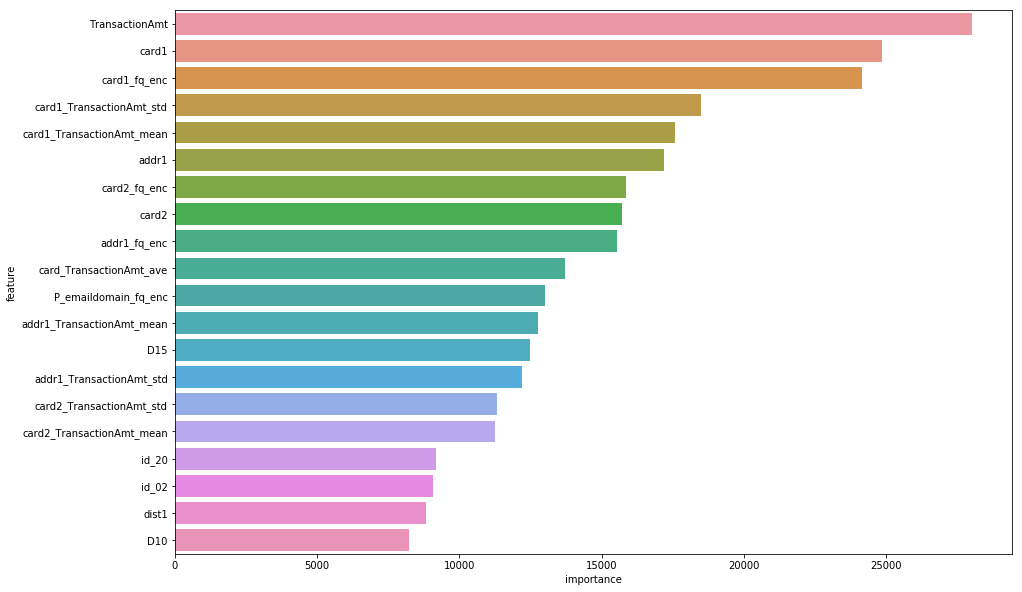

In [40]:
plt.figure(figsize=(15,10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))

In [41]:
feature_importance_df

,feature,importance
0,TransactionAmt,28016
1,card1,24858
2,card1_fq_enc,24164
3,card1_TransactionAmt_std,18495
4,card1_TransactionAmt_mean,17597
5,addr1,17178
6,card2_fq_enc,15870
7,card2,15728
8,addr1_fq_enc,15540
9,card_TransactionAmt_ave,13704


# Feature exploration TransactionAmt

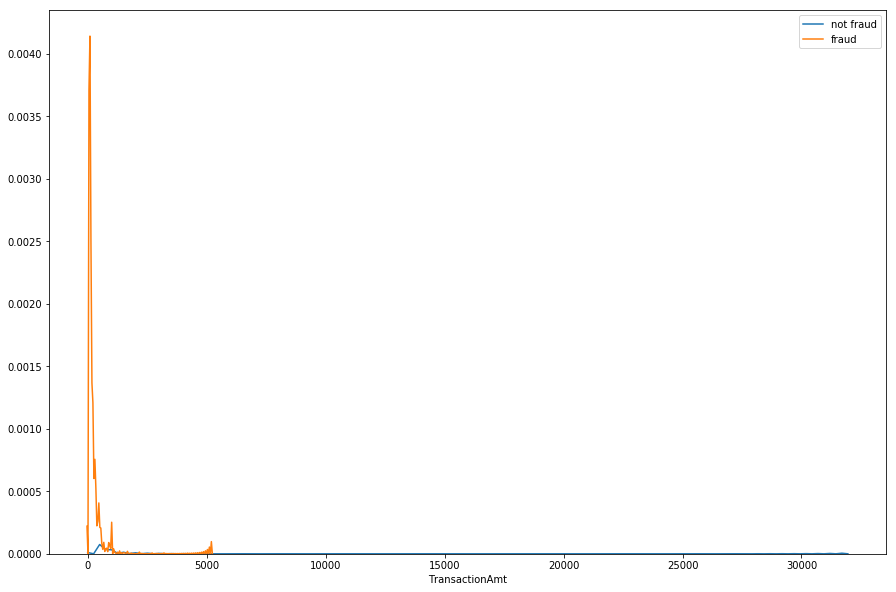

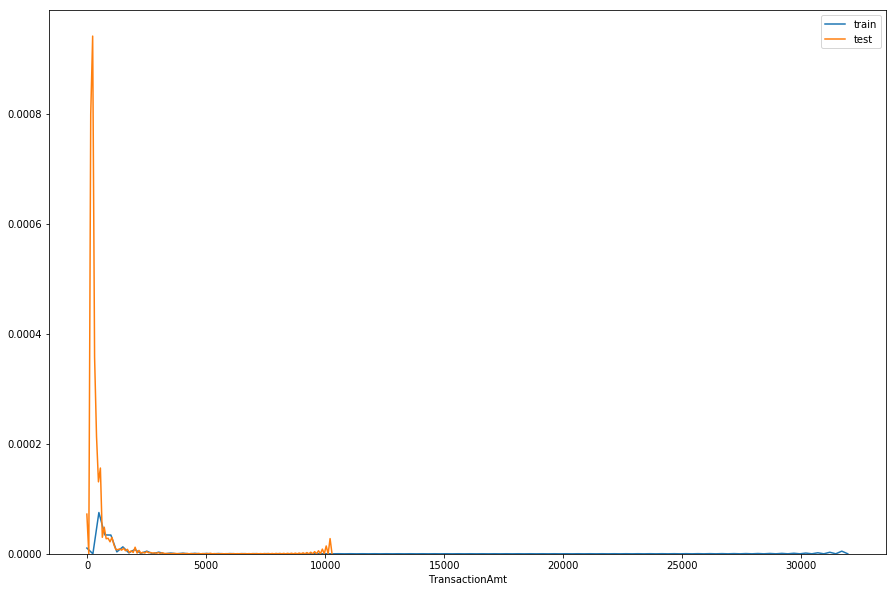

In [374]:
plt.figure(figsize=(15,10))
sns.distplot(train[(train['TransactionAmt'].isna() == False)
                           & (train['isFraud'] == 0)]['TransactionAmt'],
             label = 'not fraud', hist=False)
sns.distplot(train[(train['TransactionAmt'].isna() == False)
                           & (train['isFraud'] == 1)]['TransactionAmt'],
             label = 'fraud', hist=False)
plt.legend()

plt.figure(figsize=(15,10))
sns.distplot(train[(train['TransactionAmt'].isna() == False)]['TransactionAmt'],
             label = 'train', hist=False)
sns.distplot(test[(test['TransactionAmt'].isna() == False)]['TransactionAmt'],
             label = 'test', hist=False)
plt.legend()

In [377]:
temp_df = pd.DataFrame(data={'TransactionAmt': train['TransactionAmt'],
                                    'isFraud': train['isFraud']})

In [382]:
tree_obj = DecisionTreeClassifier(random_state=SEED, max_depth=3)

In [383]:
tree_fit = tree_obj.fit(temp_df.drop('isFraud',axis=1),temp_df['isFraud'].values)

In [384]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(tree_fit, out_file=None,
                          feature_names=['TransactionAmt'],  
                          class_names=['not Fraud', 'Fraud'],  
                          filled=True, rounded=True,  
                          special_characters=True) 
graph = graphviz.Source(dot_data)

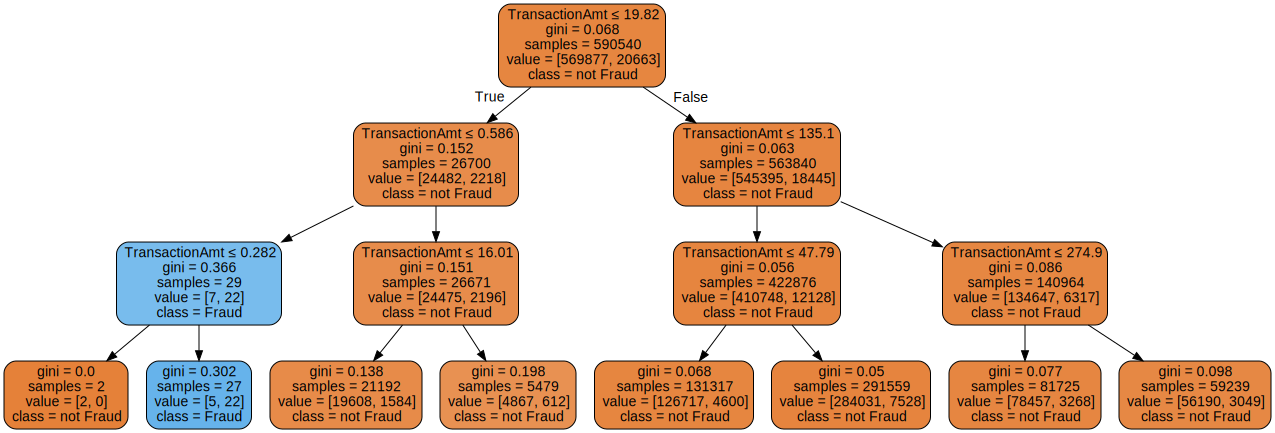

In [385]:
graph

Fraud committed in small amounts it looks like

In [375]:
len(train[(train['TransactionAmt'] <= 0.586)]['TransactionAmt'])

29

In [376]:
len(test[(test['TransactionAmt'] <= 0.586)]['TransactionAmt'])

15

Different distributions between train and test though - maybe model will overfit on this feature?

## card1_TransactionAmt

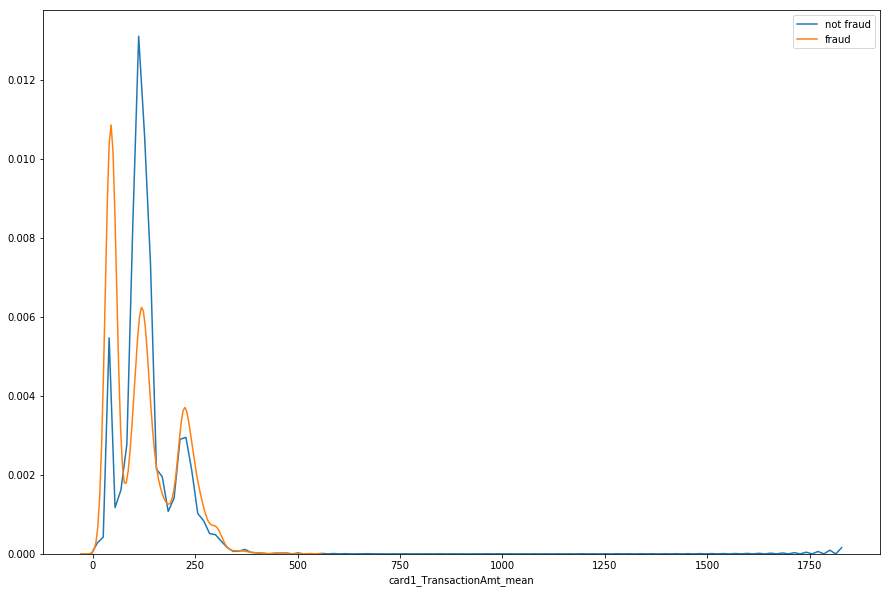

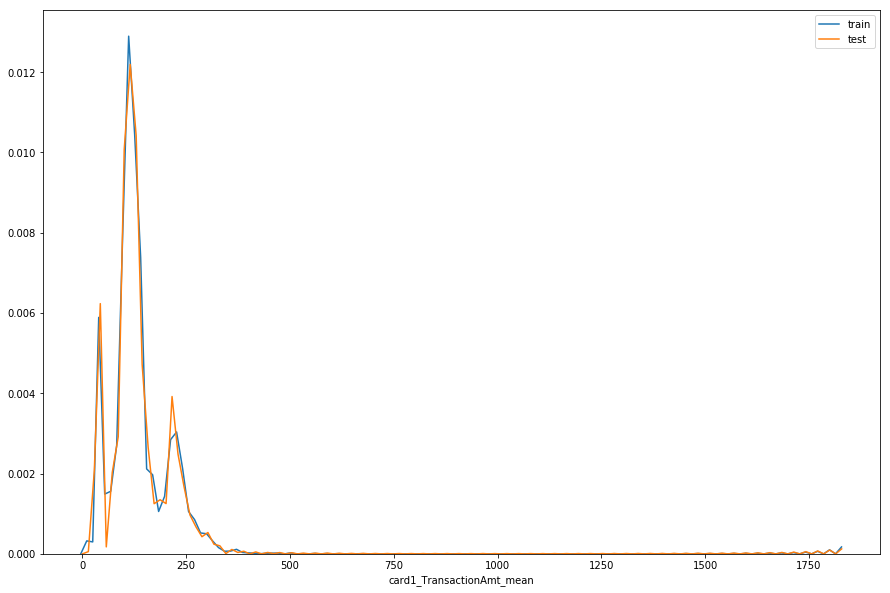

In [373]:
plt.figure(figsize=(15,10))
sns.distplot(train[(train['card1_TransactionAmt_mean'].isna() == False)
                           & (train['isFraud'] == 0)]['card1_TransactionAmt_mean'],
             label = 'not fraud', hist=False)
sns.distplot(train[(train['card1_TransactionAmt_mean'].isna() == False)
                           & (train['isFraud'] == 1)]['card1_TransactionAmt_mean'],
             label = 'fraud', hist=False)
plt.legend()

plt.figure(figsize=(15,10))
sns.distplot(train[(train['card1_TransactionAmt_mean'].isna() == False)]['card1_TransactionAmt_mean'],
             label = 'train', hist=False)
sns.distplot(test[(test['card1_TransactionAmt_mean'].isna() == False)]['card1_TransactionAmt_mean'],
             label = 'test', hist=False)
plt.legend()

In [290]:
temp_df = pd.DataFrame(data={'card1_TransactionAmt_mean': np.where(train['card1_TransactionAmt_mean'].isna(),
                                                                   -999,
                                                                   train['card1_TransactionAmt_mean']),
                                    'isFraud': train['isFraud']})

In [295]:
tree_obj = DecisionTreeClassifier(random_state=SEED, max_depth=3)

In [296]:
tree_fit = tree_obj.fit(temp_df.drop('isFraud',axis=1),temp_df['isFraud'].values)

In [297]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(tree_fit, out_file=None,
                          feature_names=['card1_TransactionAmt_mean'],  
                          class_names=['not Fraud', 'Fraud'],  
                          filled=True, rounded=True,  
                          special_characters=True) 
graph = graphviz.Source(dot_data)

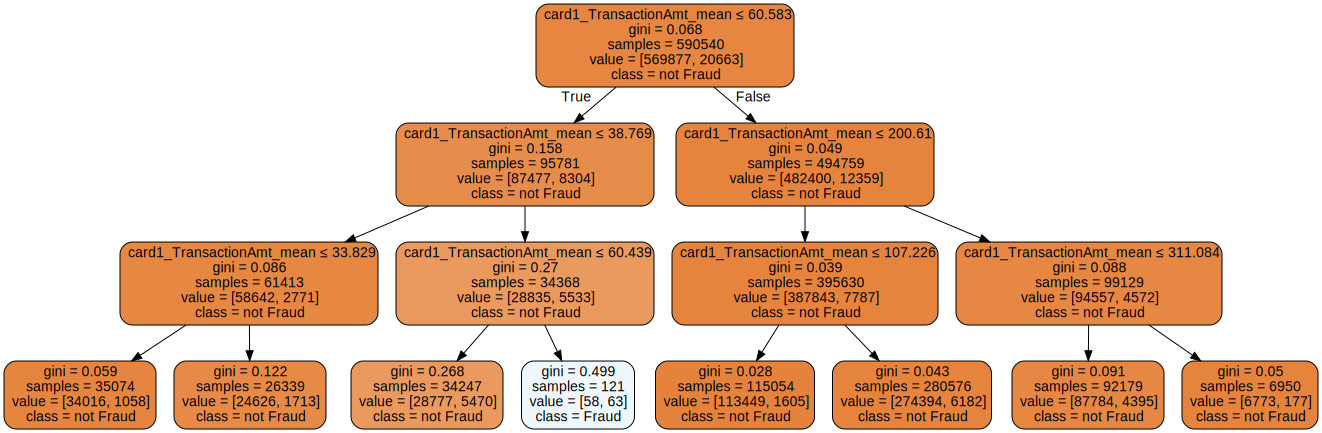

In [298]:
graph

Picked out spike of fraud between 38 and 60 in card1_TransactionAmt_mean. This feature has extremely similar distribution in train and test so will also likely perform well in scoring.

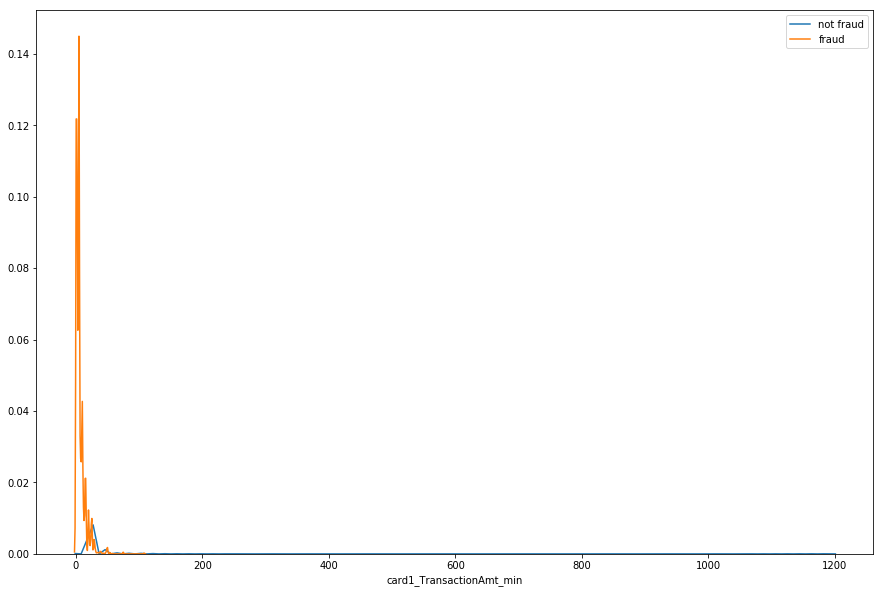

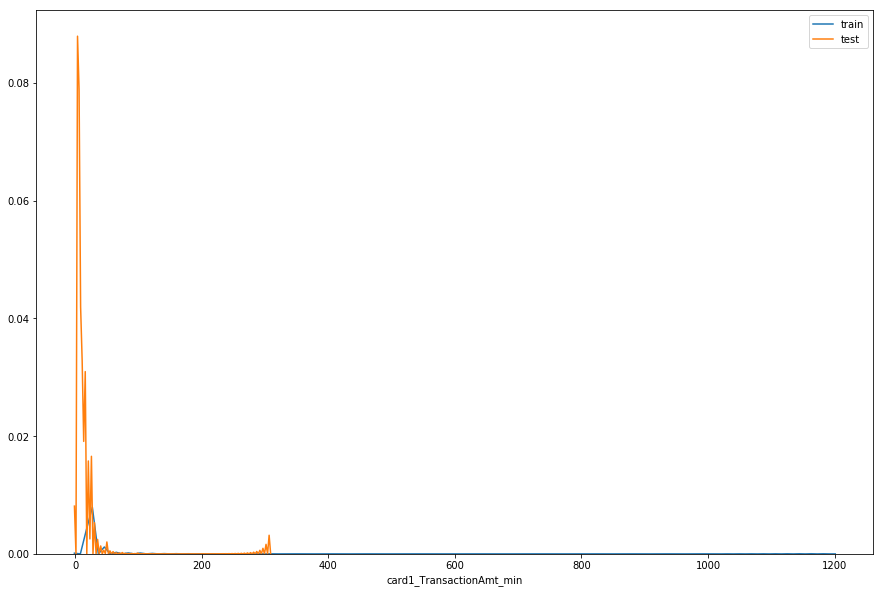

In [372]:
plt.figure(figsize=(15,10))
sns.distplot(train[(train['card1_TransactionAmt_min'].isna() == False)
                           & (train['isFraud'] == 0)]['card1_TransactionAmt_min'],
             label = 'not fraud', hist=False)
sns.distplot(train[(train['card1_TransactionAmt_min'].isna() == False)
                           & (train['isFraud'] == 1)]['card1_TransactionAmt_min'],
             label = 'fraud', hist=False)
plt.legend()

plt.figure(figsize=(15,10))
sns.distplot(train[(train['card1_TransactionAmt_min'].isna() == False)]['card1_TransactionAmt_min'],
             label = 'train', hist=False)
sns.distplot(test[(test['card1_TransactionAmt_min'].isna() == False)]['card1_TransactionAmt_min'],
             label = 'test', hist=False)
plt.legend()

In [367]:
temp_df = pd.DataFrame(data={'card1_TransactionAmt_min': np.where(train['card1_TransactionAmt_min'].isna(),
                                                                   -999,
                                                                   train['card1_TransactionAmt_min']),
                                    'isFraud': train['isFraud']})

In [368]:
tree_obj = DecisionTreeClassifier(random_state=SEED, max_depth=6)

In [369]:
tree_fit = tree_obj.fit(temp_df.drop('isFraud',axis=1),temp_df['isFraud'].values)

In [370]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(tree_fit, out_file=None,
                          feature_names=['card1_TransactionAmt_min'],  
                          class_names=['not Fraud', 'Fraud'],  
                          filled=True, rounded=True,  
                          special_characters=True) 
graph = graphviz.Source(dot_data)

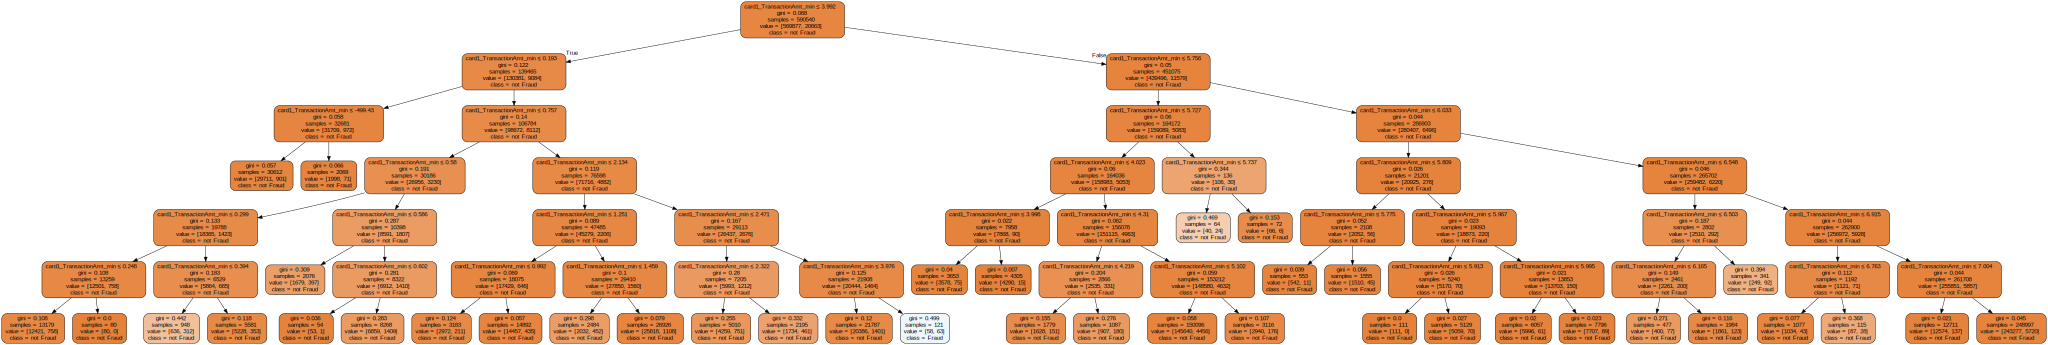

In [371]:
graph

Distributions are pretty different between train and test - these splits may not be applicable

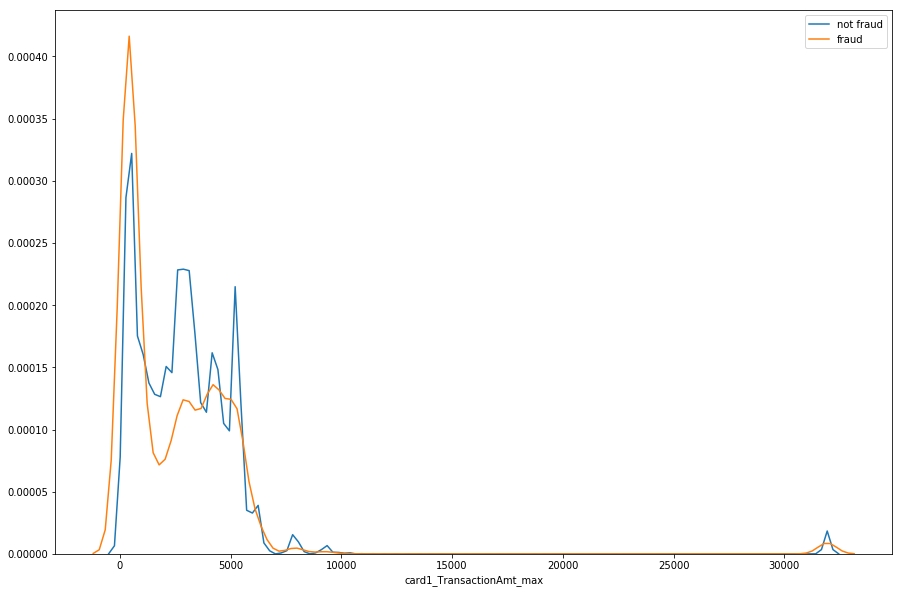

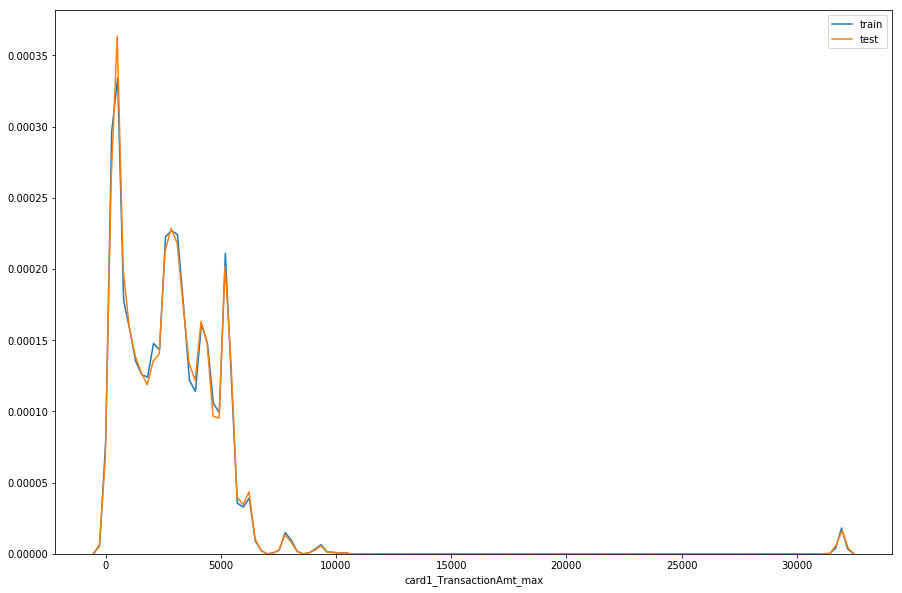

In [386]:
plt.figure(figsize=(15,10))
sns.distplot(train[(train['card1_TransactionAmt_max'].isna() == False)
                           & (train['isFraud'] == 0)]['card1_TransactionAmt_max'],
             label = 'not fraud', hist=False)
sns.distplot(train[(train['card1_TransactionAmt_max'].isna() == False)
                           & (train['isFraud'] == 1)]['card1_TransactionAmt_max'],
             label = 'fraud', hist=False)
plt.legend()

plt.figure(figsize=(15,10))
sns.distplot(train[(train['card1_TransactionAmt_max'].isna() == False)]['card1_TransactionAmt_max'],
             label = 'train', hist=False)
sns.distplot(test[(test['card1_TransactionAmt_max'].isna() == False)]['card1_TransactionAmt_max'],
             label = 'test', hist=False)
plt.legend()

In [395]:
temp_df = pd.DataFrame(data={'card1_TransactionAmt_max': np.where(train['card1_TransactionAmt_max'].isna(),
                                                                   -999,
                                                                   train['card1_TransactionAmt_max']),
                                    'isFraud': train['isFraud']})

In [404]:
tree_obj = DecisionTreeClassifier(random_state=SEED, max_depth=5)

In [405]:
tree_fit = tree_obj.fit(temp_df.drop('isFraud',axis=1),temp_df['isFraud'].values)

In [406]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(tree_fit, out_file=None,
                          feature_names=['card1_TransactionAmt_max'],  
                          class_names=['not Fraud', 'Fraud'],  
                          filled=True, rounded=True,  
                          special_characters=True) 
graph = graphviz.Source(dot_data)

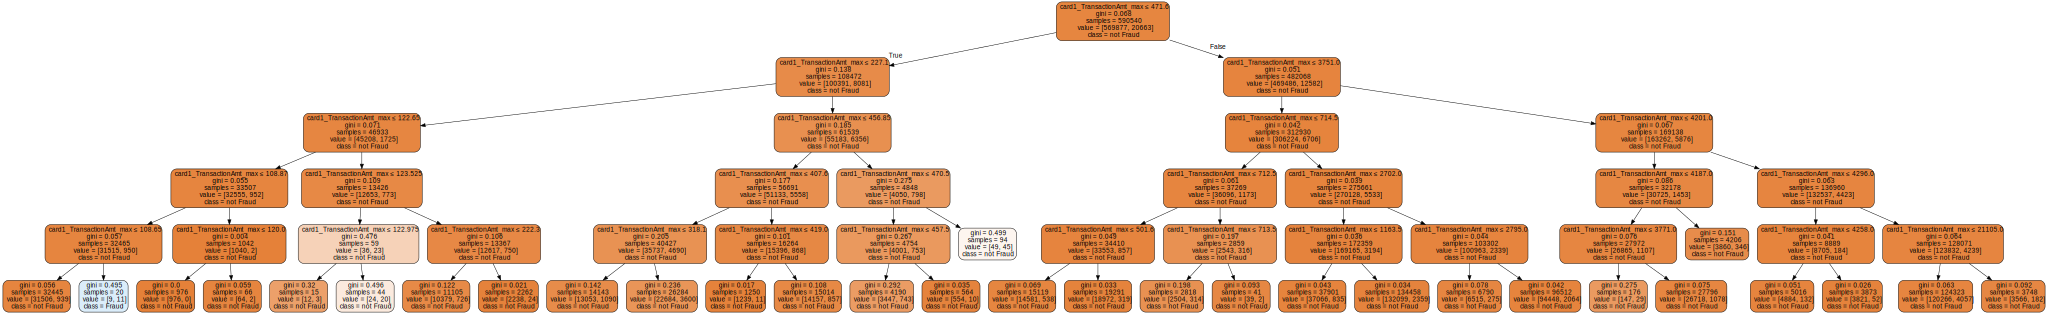

In [407]:
graph

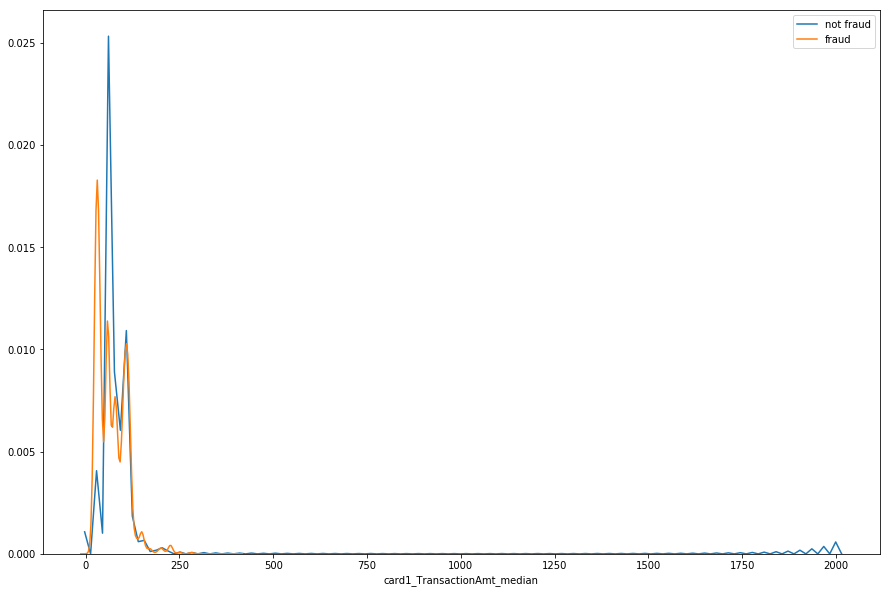

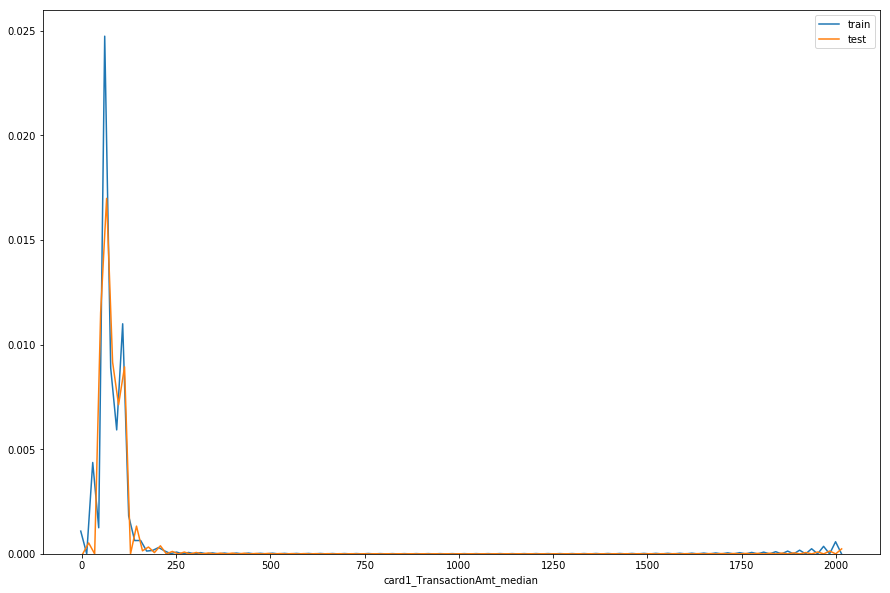

In [336]:
plt.figure(figsize=(15,10))
sns.distplot(train[(train['card1_TransactionAmt_median'].isna() == False)
                           & (train['isFraud'] == 0)]['card1_TransactionAmt_median'],
             label = 'not fraud', hist=False)
sns.distplot(train[(train['card1_TransactionAmt_median'].isna() == False)
                           & (train['isFraud'] == 1)]['card1_TransactionAmt_median'],
             label = 'fraud', hist=False)
plt.legend()

plt.figure(figsize=(15,10))
sns.distplot(train[(train['card1_TransactionAmt_median'].isna() == False)]['card1_TransactionAmt_median'],
             label = 'train', hist=False)
sns.distplot(test[(test['card1_TransactionAmt_median'].isna() == False)]['card1_TransactionAmt_median'],
             label = 'test', hist=False)
plt.legend()

In [326]:
temp_df = pd.DataFrame(data={'card1_TransactionAmt_median': np.where(train['card1_TransactionAmt_median'].isna(),
                                                                   -999,
                                                                   train['card1_TransactionAmt_median']),
                                    'isFraud': train['isFraud']})

In [345]:
temp_df = pd.DataFrame(data={'card1_TransactionAmt_median': train[train['card1_TransactionAmt_median'].isna()==False]
                             ['card1_TransactionAmt_median'],
                                    'isFraud': train[train['card1_TransactionAmt_median'].isna()==False]['isFraud']})

In [346]:
temp_df

,card1_TransactionAmt_median,isFraud
0,150.000,0
1,108.500,0
2,59.000,0
3,59.000,0
4,104.470,0
6,59.000,0
7,82.940,0
8,75.250,0
9,60.880,0
11,25.450,0


In [355]:
tree_obj = DecisionTreeClassifier(random_state=SEED, max_depth=8)

In [356]:
tree_fit = tree_obj.fit(temp_df.drop('isFraud',axis=1),temp_df['isFraud'].values)

In [357]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(tree_fit, out_file=None,
                          feature_names=['card1_TransactionAmt_median'],  
                          class_names=['not Fraud', 'Fraud'],  
                          filled=True, rounded=True,  
                          special_characters=True) 
graph = graphviz.Source(dot_data)

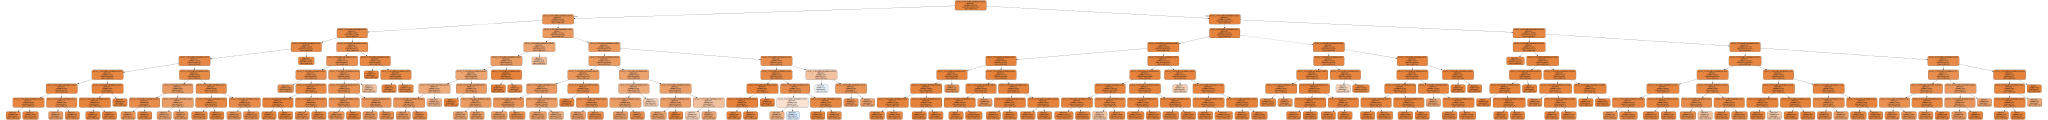

In [358]:
graph

Tree needs to grow to a decent depth before it starts to box off areas of fraud. Just because you don't see Fraud classification in first few levels doesn't mean feature isn't useful

In [361]:
train[(train['card1_TransactionAmt_median'] <= 46.285) &
     (train['card1_TransactionAmt_median'] > 46.165)]['card1_TransactionAmt_median'].value_counts()

46.17    121
Name: card1_TransactionAmt_median, dtype: int64

In [360]:
test[(test['card1_TransactionAmt_median'] <= 46.285) &
     (test['card1_TransactionAmt_median'] > 46.165)]['card1_TransactionAmt_median'].value_counts()

46.17    75
Name: card1_TransactionAmt_median, dtype: int64

In [365]:
len(train[(train['card1_TransactionAmt_median'] <= 46.845)]['card1_TransactionAmt_median'])

64945

In [366]:
len(test[(test['card1_TransactionAmt_median'] <= 46.845)]['card1_TransactionAmt_median'])

62283

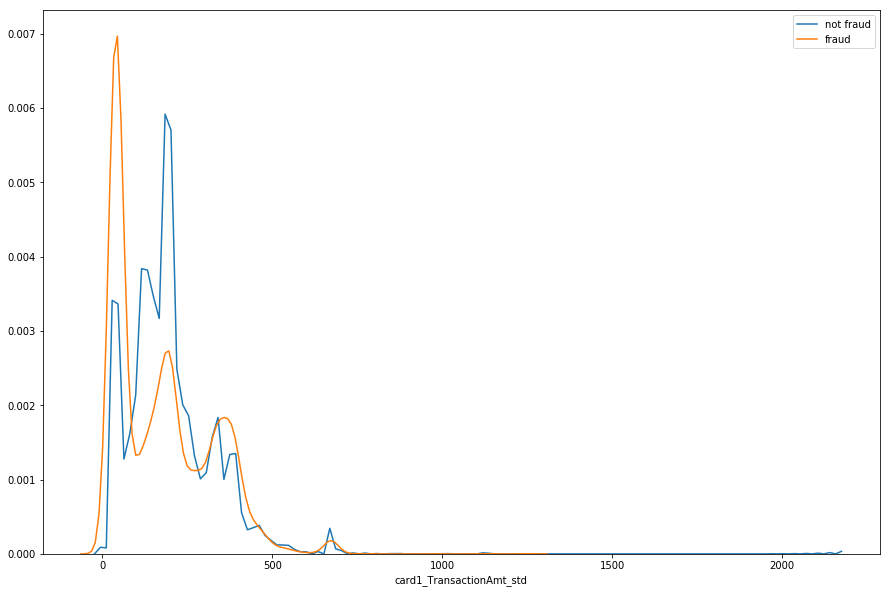

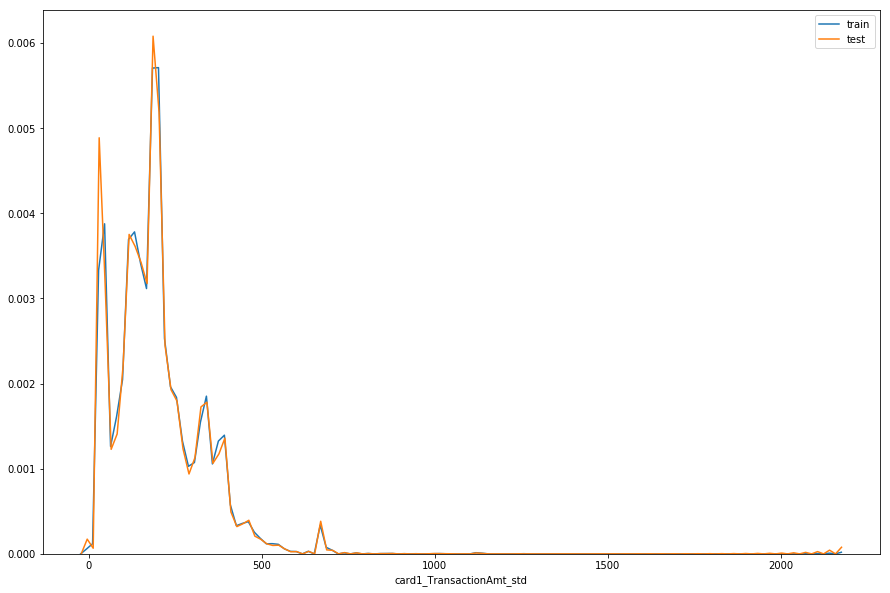

In [408]:
plt.figure(figsize=(15,10))
sns.distplot(train[(train['card1_TransactionAmt_std'].isna() == False)
                           & (train['isFraud'] == 0)]['card1_TransactionAmt_std'],
             label = 'not fraud', hist=False)
sns.distplot(train[(train['card1_TransactionAmt_std'].isna() == False)
                           & (train['isFraud'] == 1)]['card1_TransactionAmt_std'],
             label = 'fraud', hist=False)
plt.legend()

plt.figure(figsize=(15,10))
sns.distplot(train[(train['card1_TransactionAmt_std'].isna() == False)]['card1_TransactionAmt_std'],
             label = 'train', hist=False)
sns.distplot(test[(test['card1_TransactionAmt_std'].isna() == False)]['card1_TransactionAmt_std'],
             label = 'test', hist=False)
plt.legend()

In [409]:
temp_df = pd.DataFrame(data={'card1_TransactionAmt_std': train[train['card1_TransactionAmt_std'].isna()==False]
                             ['card1_TransactionAmt_std'],
                                    'isFraud': train[train['card1_TransactionAmt_std'].isna()==False]['isFraud']})

In [418]:
tree_obj = DecisionTreeClassifier(random_state=SEED, max_depth=5)

In [419]:
tree_fit = tree_obj.fit(temp_df.drop('isFraud',axis=1),temp_df['isFraud'].values)

In [420]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(tree_fit, out_file=None,
                          feature_names=['card1_TransactionAmt_std'],  
                          class_names=['not Fraud', 'Fraud'],  
                          filled=True, rounded=True,  
                          special_characters=True) 
graph = graphviz.Source(dot_data)

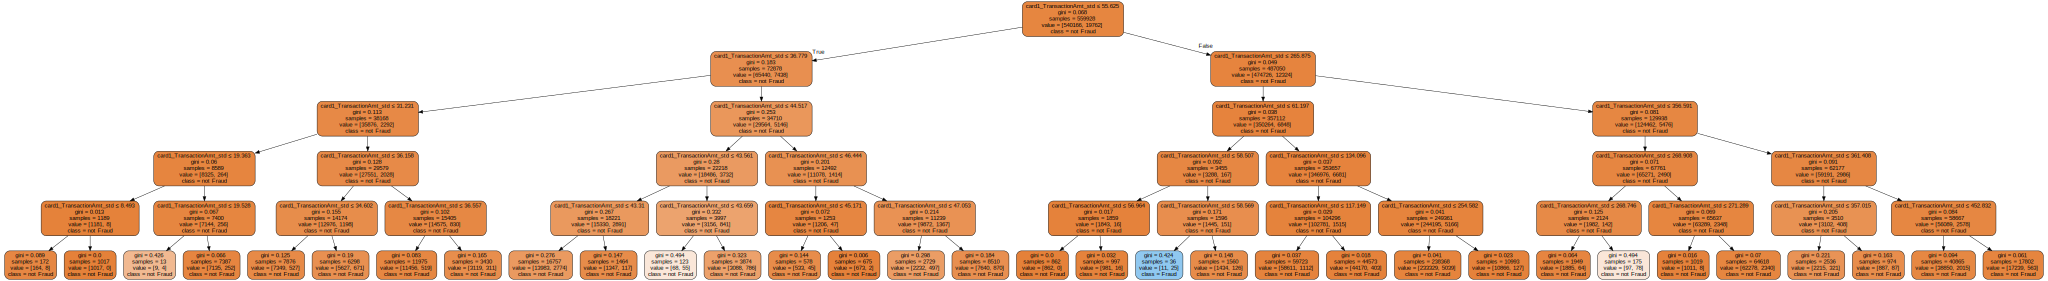

In [421]:
graph

In [12]:
new_col_name = 'card1'+'_TransactionAmt_'+'sum'
temp_df = pd.concat([train[['card1', 'TransactionAmt']], test[['card1','TransactionAmt']]])
temp_df = temp_df.groupby(['card1'])['TransactionAmt'].agg(['sum']).reset_index().rename(
                                        columns={'sum': new_col_name})

temp_df.index = list(temp_df['card1'])
temp_df = temp_df[new_col_name].to_dict()   

sampled_train[new_col_name] = sampled_train['card1'].map(temp_df)
train[new_col_name] = train['card1'].map(temp_df)
test[new_col_name] = test['card1'].map(temp_df)

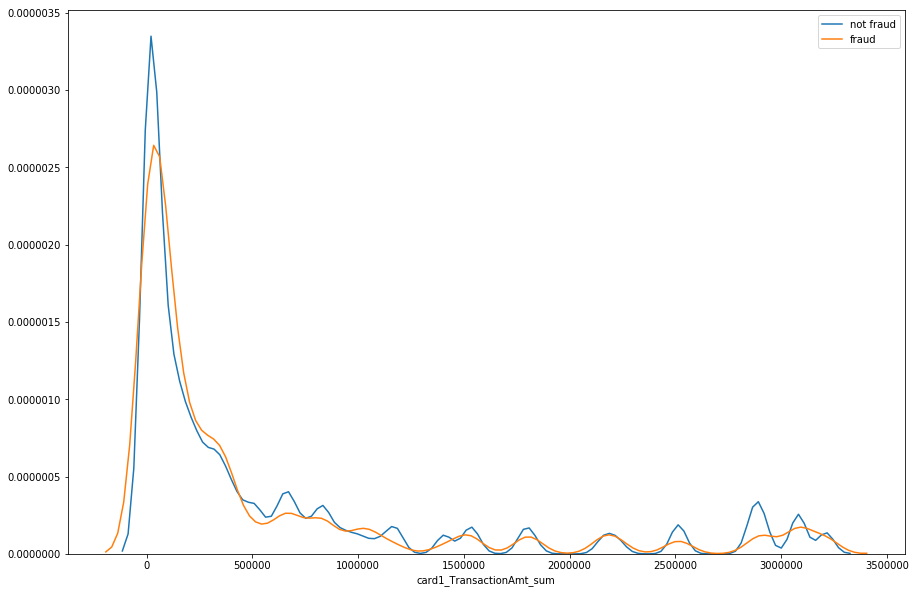

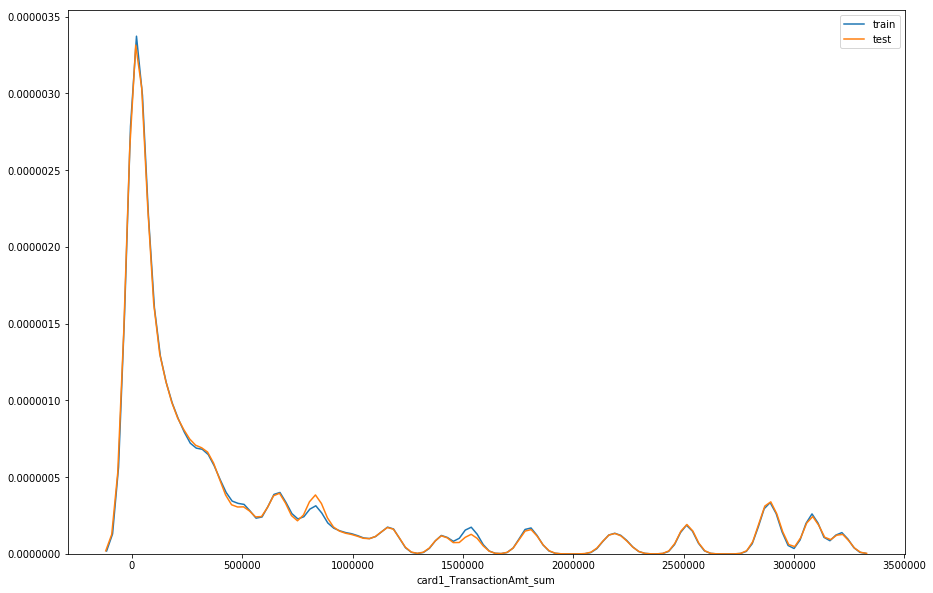

In [13]:
plt.figure(figsize=(15,10))
sns.distplot(train[(train['card1_TransactionAmt_sum'].isna() == False)
                           & (train['isFraud'] == 0)]['card1_TransactionAmt_sum'],
             label = 'not fraud', hist=False)
sns.distplot(train[(train['card1_TransactionAmt_sum'].isna() == False)
                           & (train['isFraud'] == 1)]['card1_TransactionAmt_sum'],
             label = 'fraud', hist=False)
plt.legend()

plt.figure(figsize=(15,10))
sns.distplot(train[(train['card1_TransactionAmt_sum'].isna() == False)]['card1_TransactionAmt_sum'],
             label = 'train', hist=False)
sns.distplot(test[(test['card1_TransactionAmt_sum'].isna() == False)]['card1_TransactionAmt_sum'],
             label = 'test', hist=False)
plt.legend()

In [14]:
temp_df = pd.DataFrame(data={'card1_TransactionAmt_sum': train[train['card1_TransactionAmt_sum'].isna()==False]
                             ['card1_TransactionAmt_sum'],
                                    'isFraud': train[train['card1_TransactionAmt_sum'].isna()==False]['isFraud']})

In [19]:
tree_obj = DecisionTreeClassifier(random_state=SEED, max_depth=7)

In [20]:
tree_fit = tree_obj.fit(temp_df.drop('isFraud',axis=1),temp_df['isFraud'].values)

In [21]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(tree_fit, out_file=None,
                          feature_names=['card1_TransactionAmt_sum'],  
                          class_names=['not Fraud', 'Fraud'],  
                          filled=True, rounded=True,  
                          special_characters=True) 
graph = graphviz.Source(dot_data)

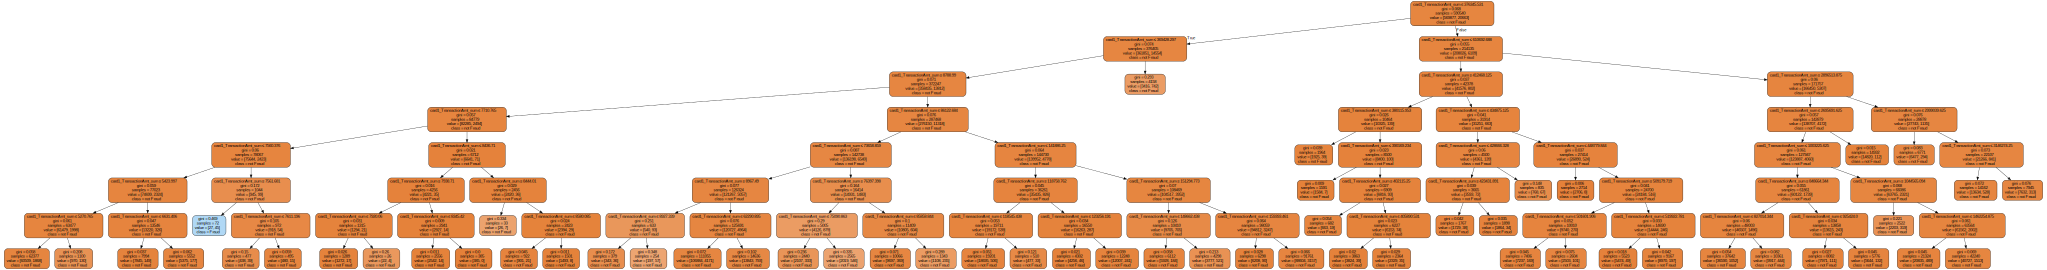

In [22]:
graph

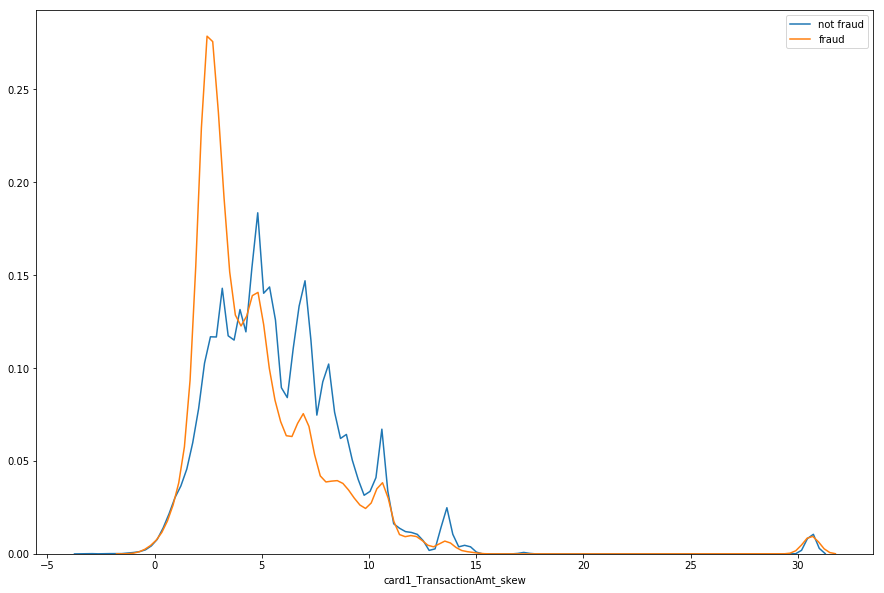

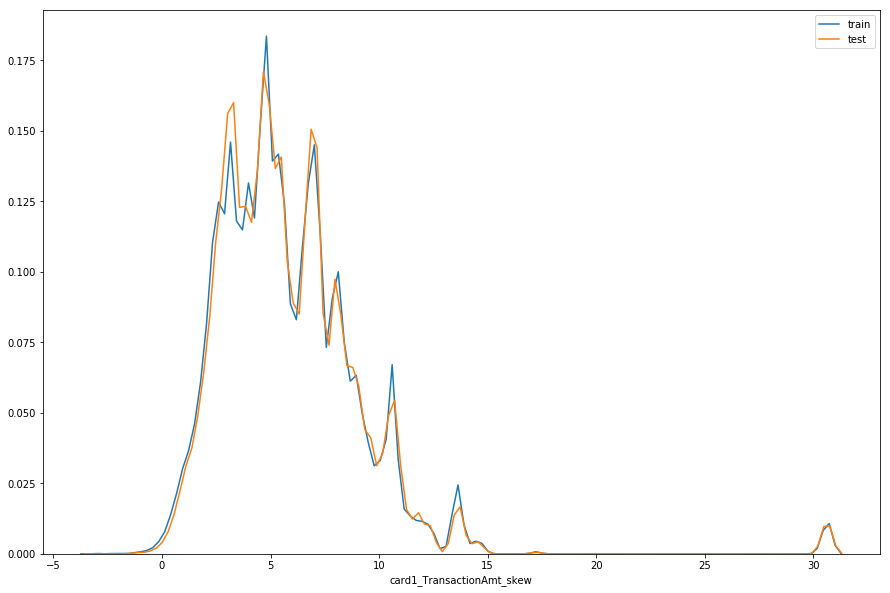

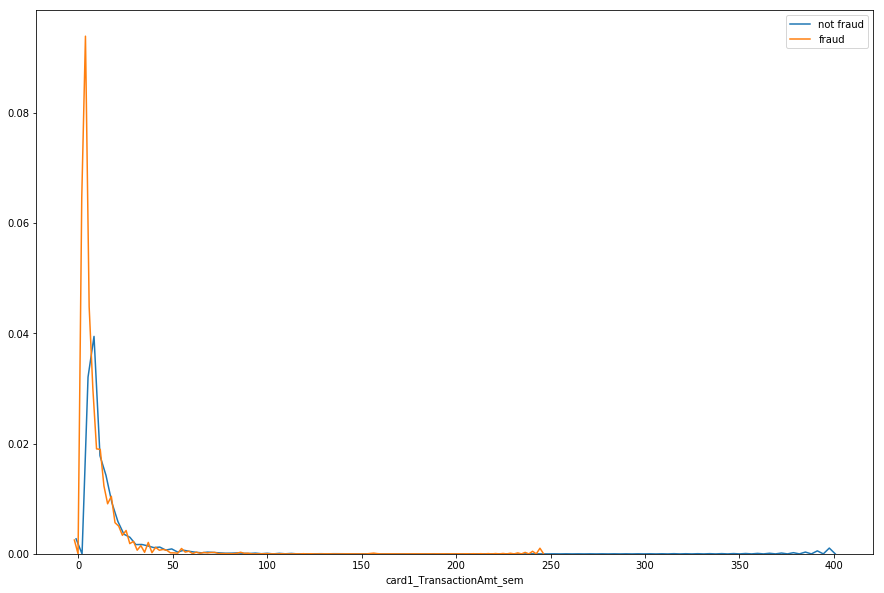

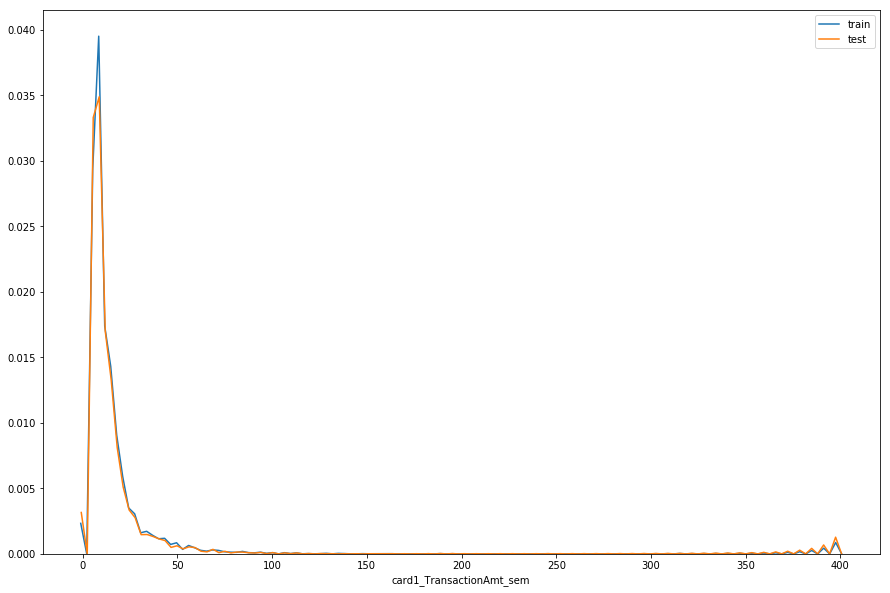

In [87]:
# for agg_type in ['skew', 'kurt', 'mode', 'prod', 'sem']:
for agg_type in ['skew', 'sem']:

    col = 'card1'
    new_col_name = col +'_TransactionAmt_'+ agg_type
    temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])
    temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                            columns={agg_type: new_col_name})

    temp_df.index = list(temp_df[col])
    temp_df = temp_df[new_col_name].to_dict()   

    train[new_col_name] = train[col].map(temp_df)
    test[new_col_name] = test[col].map(temp_df)

    plt.figure(figsize=(15,10))
    sns.distplot(train[(train[new_col_name].isna() == False)
                               & (train['isFraud'] == 0)][new_col_name],
                 label = 'not fraud', hist=False)
    sns.distplot(train[(train[new_col_name].isna() == False)
                               & (train['isFraud'] == 1)][new_col_name],
                 label = 'fraud', hist=False)
    plt.legend()

    plt.figure(figsize=(15,10))
    sns.distplot(train[(train[new_col_name].isna() == False)][new_col_name],
                 label = 'train', hist=False)
    sns.distplot(test[(test[new_col_name].isna() == False)][new_col_name],
                 label = 'test', hist=False)
    plt.legend()

In [26]:
temp_df = pd.DataFrame(data={'card1_TransactionAmt_skew': train[train['card1_TransactionAmt_skew'].isna()==False]
                             ['card1_TransactionAmt_skew'],
                                    'isFraud': train[train['card1_TransactionAmt_skew'].isna()==False]['isFraud']})

In [47]:
tree_obj = DecisionTreeClassifier(random_state=SEED, max_depth=7)

In [48]:
tree_fit = tree_obj.fit(temp_df.drop('isFraud',axis=1),temp_df['isFraud'].values)

In [49]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(tree_fit, out_file=None,
                          feature_names=['card1_TransactionAmt_skew'],  
                          class_names=['not Fraud', 'Fraud'],  
                          filled=True, rounded=True,  
                          special_characters=True) 
graph = graphviz.Source(dot_data)

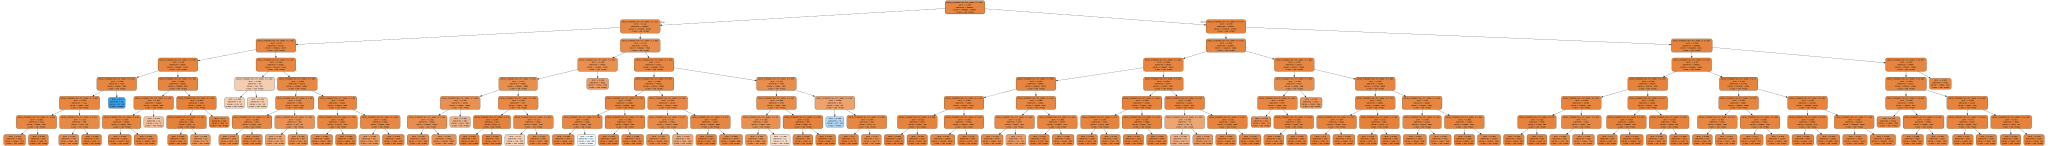

In [50]:
graph

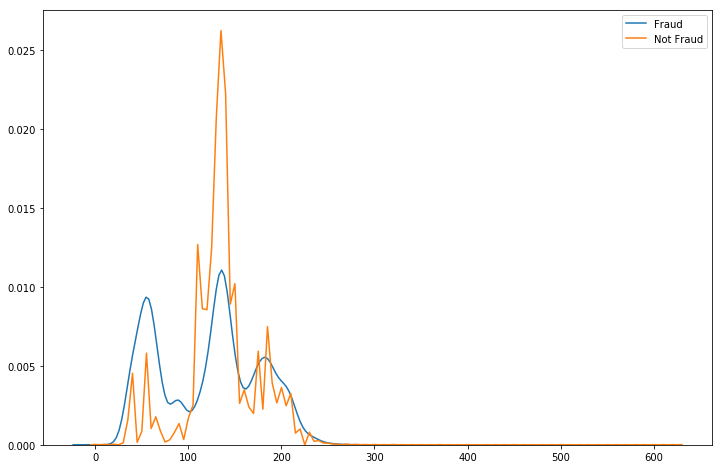

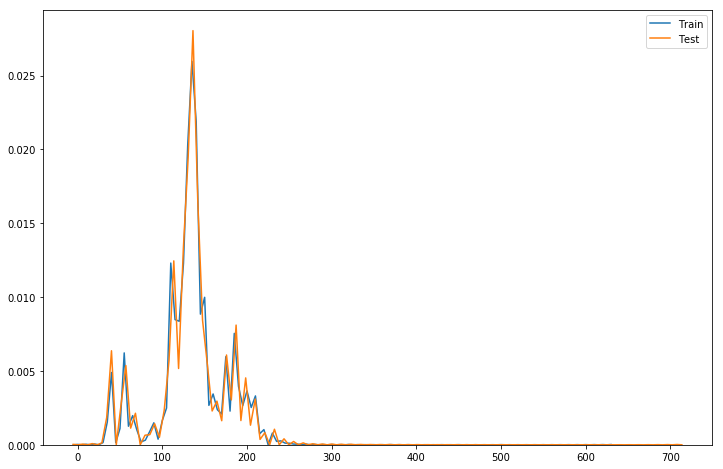

In [267]:
plt.figure(figsize=(12,8))
sns.distplot(train[train['isFraud']==1][['card1_TransactionAmt_mean', 'card2_TransactionAmt_mean', 'card3_TransactionAmt_mean',
               'card5_TransactionAmt_mean']].mean(axis=1).fillna(0), hist=False,
            label='Fraud')
sns.distplot(train[train['isFraud']==0][['card1_TransactionAmt_mean', 'card2_TransactionAmt_mean', 'card3_TransactionAmt_mean',
               'card5_TransactionAmt_mean']].mean(axis=1).fillna(0), hist=False,
            label = 'Not Fraud')
plt.legend()


plt.figure(figsize=(12,8))
sns.distplot(train[['card1_TransactionAmt_mean', 'card2_TransactionAmt_mean', 'card3_TransactionAmt_mean',
               'card5_TransactionAmt_mean']].mean(axis=1).fillna(0), hist=False,
            label='Train')
sns.distplot(test[['card1_TransactionAmt_mean', 'card2_TransactionAmt_mean', 'card3_TransactionAmt_mean',
               'card5_TransactionAmt_mean']].mean(axis=1).fillna(0), hist=False,
            label = 'Test')
plt.legend()

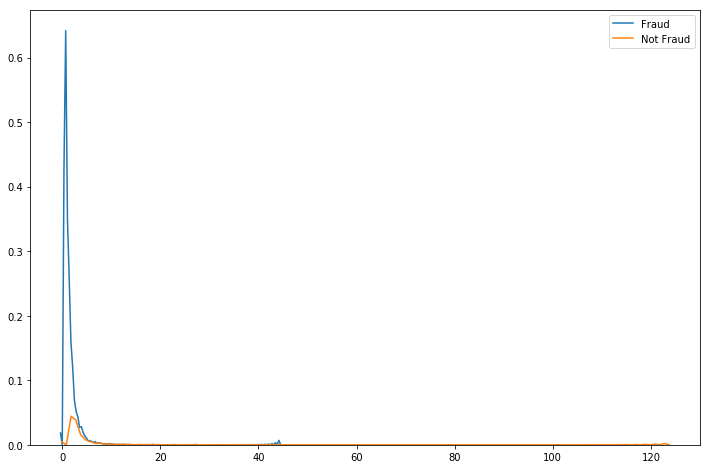

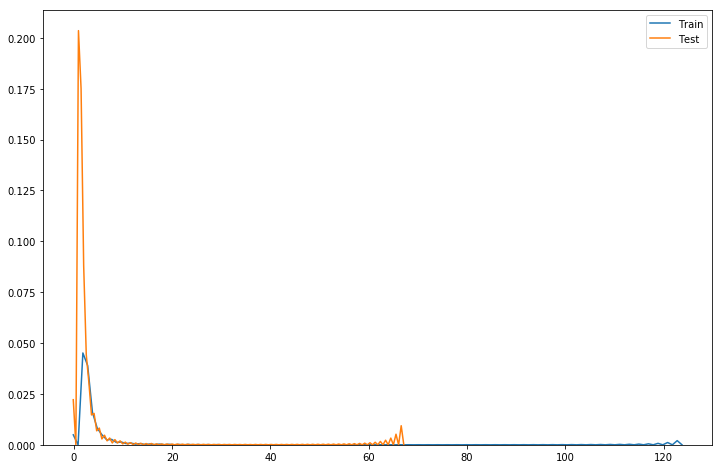

In [268]:
plt.figure(figsize=(12,8))
sns.distplot(train[train['isFraud']==1]['TransactionAmt'] / train[train['isFraud']==1]['card1_TransactionAmt_mean'].fillna(0),
             hist=False,
             label='Fraud')
sns.distplot(train[train['isFraud']==0]['TransactionAmt'] / train[train['isFraud']==0]['card1_TransactionAmt_mean'].fillna(0), hist=False,
            label = 'Not Fraud')
plt.legend()


plt.figure(figsize=(12,8))
sns.distplot(train['TransactionAmt'] / train['card1_TransactionAmt_mean'].fillna(0),
             hist=False,
             label='Train')
sns.distplot(test['TransactionAmt'] / test['card1_TransactionAmt_mean'].fillna(0),
             hist=False,
             label = 'Test')
plt.legend()

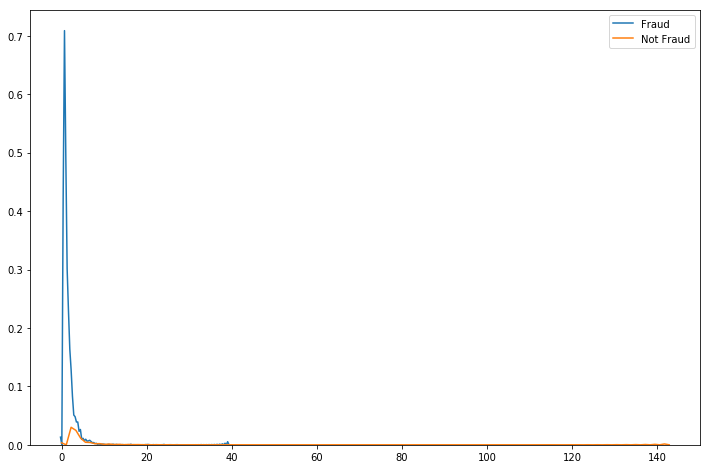

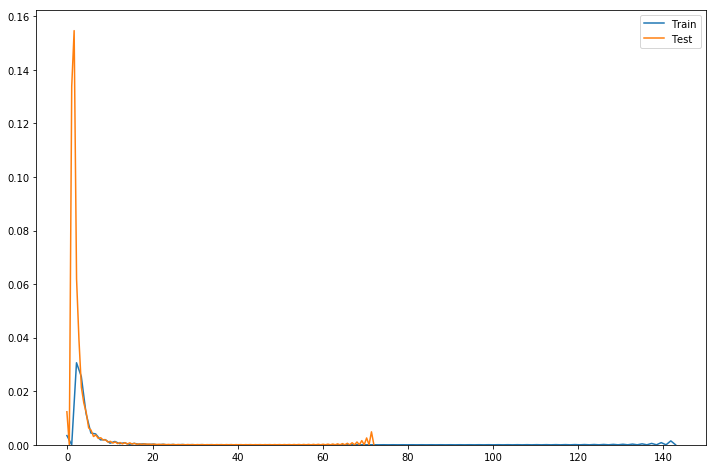

In [269]:
plt.figure(figsize=(12,8))
sns.distplot(train[train['isFraud']==1]['TransactionAmt'] / train[train['isFraud']==1]['card2_TransactionAmt_mean'].fillna(0),
             hist=False,
             label='Fraud')
sns.distplot(train[train['isFraud']==0]['TransactionAmt'] / train[train['isFraud']==0]['card2_TransactionAmt_mean'].fillna(0), hist=False,
            label = 'Not Fraud')
plt.legend()


plt.figure(figsize=(12,8))
sns.distplot(train['TransactionAmt'] / train['card2_TransactionAmt_mean'].fillna(0),
             hist=False,
             label='Train')
sns.distplot(test['TransactionAmt'] / test['card2_TransactionAmt_mean'].fillna(0),
             hist=False,
             label = 'Test')
plt.legend()

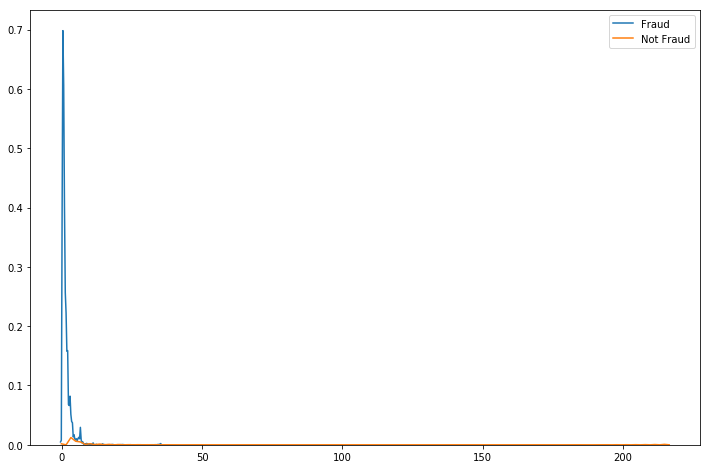

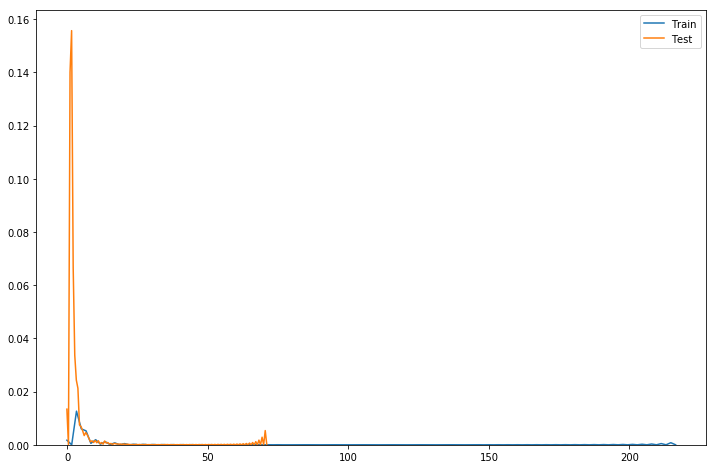

In [270]:
plt.figure(figsize=(12,8))
sns.distplot(train[train['isFraud']==1]['TransactionAmt'] / train[train['isFraud']==1]['card3_TransactionAmt_mean'].fillna(0),
             hist=False,
             label='Fraud')
sns.distplot(train[train['isFraud']==0]['TransactionAmt'] / train[train['isFraud']==0]['card3_TransactionAmt_mean'].fillna(0), hist=False,
            label = 'Not Fraud')
plt.legend()


plt.figure(figsize=(12,8))
sns.distplot(train['TransactionAmt'] / train['card3_TransactionAmt_mean'].fillna(0),
             hist=False,
             label='Train')
sns.distplot(test['TransactionAmt'] / test['card3_TransactionAmt_mean'].fillna(0),
             hist=False,
             label = 'Test')
plt.legend()

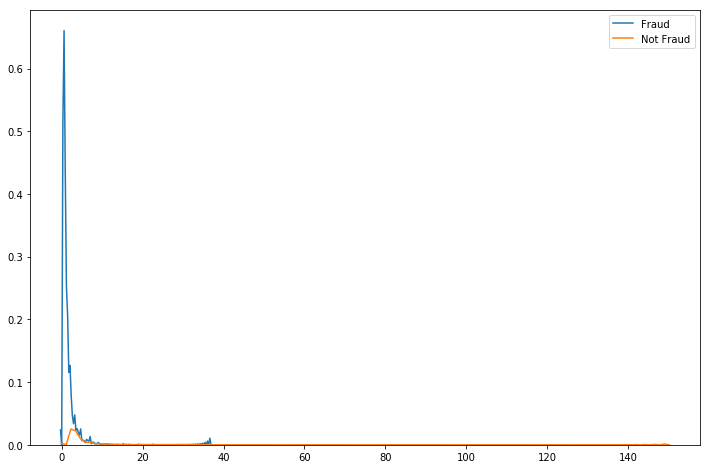

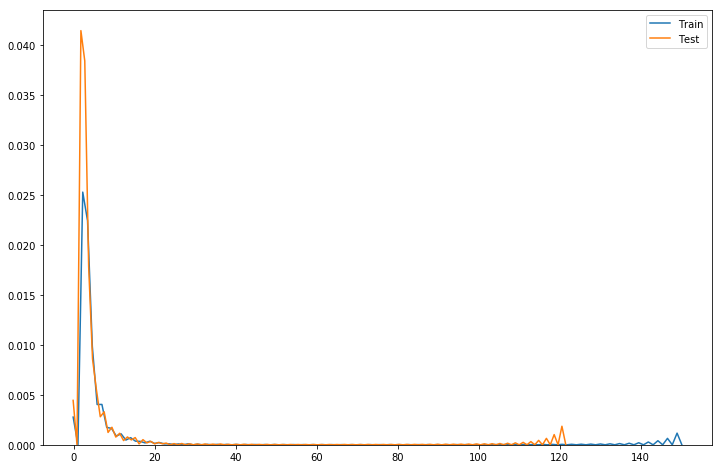

In [271]:
plt.figure(figsize=(12,8))
sns.distplot(train[train['isFraud']==1]['TransactionAmt'] / train[train['isFraud']==1]['card5_TransactionAmt_mean'].fillna(0),
             hist=False,
             label='Fraud')
sns.distplot(train[train['isFraud']==0]['TransactionAmt'] / train[train['isFraud']==0]['card5_TransactionAmt_mean'].fillna(0), hist=False,
            label = 'Not Fraud')
plt.legend()


plt.figure(figsize=(12,8))
sns.distplot(train['TransactionAmt'] / train['card5_TransactionAmt_mean'].fillna(0),
             hist=False,
             label='Train')
sns.distplot(test['TransactionAmt'] / test['card5_TransactionAmt_mean'].fillna(0),
             hist=False,
             label = 'Test')
plt.legend()